# FairClaim: Fraud Detection for Sustainable Insurance
notebook 2

Table of content

- [Feature Engineering Plan](#feature-engineering-plan)
- [Ablation Plan and Preprocess](#ablation-plan-and-preprocess)
- [Baseline Model And Ablation Testl](#baseline-model-and-ablation-test)
- [Logistic Regression: Imbalance Strategies](#logistic-regression-imbalance-strategies)
- [Top-K Metrics - Fraud Prioritization](#top-k-metrics-fraud-prioritization)
- [Feature Engineering Step 2 - Domain Signals](#feature-engineering-step-2-domain-signals)
- [Tree Boosting Model - CatBoost](#tree-boosting-model-catBoost)
- [Error analysis — Missed Fraud Cases](#error-analysis—missed-fraud-cases)
- [Model Explainability (SHAP)](#model-explainability-shap)
- [Final Summary & Ethical Reflection](#final-summary-ethical-reflection)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
import re
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
import itertools
import matplotlib.cm as cm

## <a id="feature-engineering-plan"></a>Feature Engineering Plan


### Recap of EDA-driven engineered features

During EDA we created a small set of derived features to capture **timing** and **structure anomalies** observed in the raw columns.  
These features were motivated by sanity checks and subgroup fraud-rate patterns, not by automated feature mining.

**Engineered features created in EDA**
- **`lag_bin_2`, `lag_bin_3`** (`0`, `1`, `2+`): binned claim delay in months computed from `Month` vs `MonthClaimed`.  
  Motivation: crosstab + chi-square tests showed a significant association between longer delays and higher fraud rate.
- **`sport_sedan_mismatch`** (bool): flags the observed structural inconsistency between `VehicleCategory` and `VehicleGroup` in the dataset.  
  Motivation: EDA revealed a near-deterministic mapping pattern; we treat this as a dataset-specific artifact/proxy and keep it only for controlled ablation tests.

We do not assume these engineered features must be used in the final model.  
Instead, we will evaluate them via **ablation scenarios** in the modeling notebook (baseline vs feature-set variants) to avoid overfitting decisions to this data


In [2]:
df = pd.read_csv('PATH/data_claim') # your path here

In [3]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,NumberOfCars,Year,VehicleGroup,CoverageType,sport_sedan_mismatch,month_num,claimed_num,claim_lag_months,lag_bin_2,lag_bin_3
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 to 4,1994,Sport,Liability,False,12,1,1,lag>0,1
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,1 vehicle,1994,Sport,Collision,False,1,1,0,lag=0,0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,1 vehicle,1994,Sport,Collision,False,10,11,1,lag>0,1
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,1 vehicle,1994,Sedan,Liability,True,6,7,1,lag>0,1
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,1 vehicle,1994,Sport,Collision,False,1,2,1,lag>0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15419 non-null  object
 1   WeekOfMonth           15419 non-null  int64 
 2   DayOfWeek             15419 non-null  object
 3   Make                  15419 non-null  object
 4   AccidentArea          15419 non-null  object
 5   DayOfWeekClaimed      15419 non-null  object
 6   MonthClaimed          15419 non-null  object
 7   WeekOfMonthClaimed    15419 non-null  int64 
 8   Sex                   15419 non-null  object
 9   MaritalStatus         15419 non-null  object
 10  Age                   15419 non-null  int64 
 11  Fault                 15419 non-null  object
 12  PolicyType            15419 non-null  object
 13  VehicleCategory       15419 non-null  object
 14  VehiclePrice          15419 non-null  object
 15  FraudFound_P          15419 non-null

**Columns dropped**
We drop ID-like and helper columns created only for intermediate calculations:
- ID/proxy: `PolicyNumber`, `RepNumber`
- helper columns created duirng EDA
- week of month accident/claim as we have not seen strong signal from it during EDA
- `claim_lag_months` as we alreayd have the same signal from `lag_bin_3`

These are removed to reduce noise and prevent accidental leakage of intermediate encodings

In [5]:
# Drop NOW: helper columns we made for EDA and PolicyNumber as unique coded ID

drop_now = ["RepNumber",
    "PolicyNumber",
    "month_num", "claimed_num",
    "dow_num", "dow_claimed_num",
    "claim_lag_months", "claim_lag_dow",
    "WeekOfMonth", "WeekOfMonthClaimed",
    
]

df = df.drop(columns=[c for c in drop_now if c in df.columns])

df.shape, df.columns

((15419, 33),
 Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
        'MonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType',
        'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'Deductible',
        'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
        'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
        'PoliceReportFiled', 'WitnessPresent', 'AgentType',
        'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
        'VehicleGroup', 'CoverageType', 'sport_sedan_mismatch', 'lag_bin_2',
        'lag_bin_3'],
       dtype='object'))

We consider our list of business features strong already and will avoid adding multiple features before baseline and ablation test. However, two simple boolean flags as interpretable summaries of existing categorical fields might be useful. It do not introduce new information beyond the original columns, but provide a compact signal that is easy to ablate and discuss.

- **`has_past_claims`**: `PastNumberOfClaims != "none"`.  
  Motivation: separates first-time claimants from those with any prior claim history.

- **`strong_process_evidence`**: `PoliceReportFiled == "Yes" OR WitnessPresent == "Yes"`.  
  Motivation: captures the presence of formal documentation / witnesses as a potential process-related indicator
  (could be an anti-fraud signal, but we validate its impact via ablation).

In [6]:
df = df.copy()
    
# past claims flag (behavior/history)
# PastNumberOfClaims categories: ['none', '1', '2 to 4', 'more than 4']

df["has_past_claims"] = (df["PastNumberOfClaims"].astype(str).str.lower() != "none")
    
# process evidence flag (process/handling proxy)
# PoliceReportFiled, WitnessPresent: typically 'Yes'/'No'

police_yes = df["PoliceReportFiled"].astype(str).str.strip().str.lower().eq("yes")
witness_yes = df["WitnessPresent"].astype(str).str.strip().str.lower().eq("yes")
df["strong_process_evidence"] = police_yes | witness_yes

In [7]:
df[["strong_process_evidence", "has_past_claims"]].value_counts()

strong_process_evidence  has_past_claims
False                    True               10724
                         False               4220
True                     True                 344
                         False                131
Name: count, dtype: int64

In [8]:
# during EDA we saw Age == 0 is most likely age of minors


df["is_under_16"] = (df["Age"] == 0).astype(int)
df["Age_clean"] = df["Age"].replace(0, np.nan)

In [9]:
df = df.drop(columns=["Age", "AgeOfPolicyHolder"])

### Age handling (minors)

As we found in EDA notebook, `Age` (numeric) contains a special-coded value 0 for under-16 / masked ages.
To avoid treating 0 as a real numeric age which would distort model geometry, we created an indicator feature `is_under_16` = (Age == 0),
replace Age == 0 with missing (NaN) and will impute missing Age using the training-set median inside the ML pipeline.

This keeps the “masked/minor” information explicitly (via the flag), while preventing the coded value from biasing the model as a genuine age.

In [10]:
df.shape

(15419, 35)

In [11]:
df.columns

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'Year', 'VehicleGroup',
       'CoverageType', 'sport_sedan_mismatch', 'lag_bin_2', 'lag_bin_3',
       'has_past_claims', 'strong_process_evidence', 'is_under_16',
       'Age_clean'],
      dtype='object')

## <a id="ablation-plan-and-preprocess"></a>Ablation Plan and Preprocess

### Ablation plan (feature-set scenarios)

Because the dataset lacks official documentation, we avoid making a single final feature decision upfront.
Instead, we evaluate multiple **feature-set scenarios** (ablation) to answer clear diagnostic questions
and to reduce the risk of overfitting our pipeline design to this specific dataset.

#### Why ablation?
- to test whether model performance is driven by **product segmentation** vs **operational/process variables**
- to detect potential **process-induced proxies** (features reflecting handling workflow rather than claimant behaviour)
- to support an **ethics/fairness** discussion by measuring how much performance depends on demographic attributes

#### Feature-set scenarios and the question each answers

| Scenario | What we remove | Question we test |
|---|---|---|
| **Baseline (All features)** | nothing (except IDs/helper columns) | What is the best achievable reference performance given the available fields? |
| **Product-agnostic** | policy/vehicle structure (e.g., `PolicyType`, `CoverageType`, `VehicleCategory`, `VehicleGroup`, `VehiclePrice`, `Make`, `AgeOfVehicle`) | Does the model still detect fraud using *behavioural/process/timing* signals, or is it mainly learning product segmentation? |
| **Process-agnostic** | operational/handling proxies (e.g., `AgentType`, `PoliceReportFiled`, `WitnessPresent`, `NumberOfSuppliments`, `Days_Policy_*`, `RepNumber`, `strong_process_evidence`) | Does the model retain signal without relying on claim-handling workflow features that may reflect process bias or post-hoc information? |
| **No demographics** | demographic attributes (`Sex`, `MaritalStatus`, `Age_сlean`, `is_under_16`,`AddressChange_Claim`) | How much predictive power comes from demographic profiling vs case/product/process characteristics? |

Also, `lag_bin_2` and `lag_bin_3` will be tested separately on baseline model so we can decide which one give more information to model

#### How we will evaluate and choose
- We will train the same baseline model(s) under each scenario using the **same temporal evaluation protocol**.
- We will compare performance (primary: ROC-AUC + minority-class recall/PR-AUC depending on the final metric choice),
  and also track operational impact (alert volume at a chosen threshold).
- The final feature set will be chosen by balancing:
  (1) performance, (2) robustness/generalization, and (3) ethical/process risk.
  If two scenarios perform similarly, we prefer the one with **lower leakage/proxy risk**.

In [12]:
# define target and ablation set

TARGET = "FraudFound_P"

# hard drop just in case!
DROP_ALWAYS = ["RepNumber",
    "PolicyNumber",
    "month_num", "claimed_num",
    "dow_num", "dow_claimed_num",
    "claim_lag_months", "claim_lag_dow",
    "WeekOfMonth", "WeekOfMonthClaimed",
]

BASE_FEATURES = [
    "Month", "DayOfWeek", "Make", "AccidentArea", "DayOfWeekClaimed",
    "MonthClaimed", "Sex", "MaritalStatus", "Fault", "PolicyType",
    "VehicleCategory", "VehiclePrice", "Deductible",
    "DriverRating", "Days_Policy_Accident", "Days_Policy_Claim",
    "PastNumberOfClaims", "AgeOfVehicle", "PoliceReportFiled",
    "WitnessPresent", "AgentType", "NumberOfSuppliments",
    "AddressChange_Claim", "NumberOfCars", "Year", "VehicleGroup",
    "CoverageType", 
    "has_past_claims", "strong_process_evidence", "is_under_16", "Age_clean"
]

# we'll not include both lag bins at the same time
LAG_OPTIONS = {
    "lag2": ["lag_bin_2"],
    "lag3": ["lag_bin_3"],
}

PRODUCT_STRUCTURE = [
    "CoverageType", "PolicyType", "VehicleCategory", "VehicleGroup",
    "VehiclePrice", "Make", "AgeOfVehicle"
]

PROCESS_WORKFLOW = [
    "AgentType", "PoliceReportFiled", "WitnessPresent",
    "Days_Policy_Accident", "Days_Policy_Claim",
    "strong_process_evidence", "NumberOfSuppliments"
]

DEMOGRAPHICS = [
    "Sex", "MaritalStatus", "Age_clean", "is_under_16", "AddressChange_Claim"
    
]

DERIVED_FLAG = "sport_sedan_mismatch"

In [13]:
def _dedup_keep_order(cols):
    seen = set()
    out = []
    for c in cols:
        if c not in seen:
            out.append(c)
            seen.add(c)
    return out


def build_base_scenarios(feature_list):


    """Return the 4 core scenarios (baseline/product/process/no_demographics) for a given feature_list."""
    
    base = _dedup_keep_order([c for c in feature_list if c != TARGET])

    scenarios = {}
    scenarios["baseline_all"] = base

    scenarios["product_agnostic"] = _dedup_keep_order([c for c in base if c not in PRODUCT_STRUCTURE])
    scenarios["process_agnostic"] = _dedup_keep_order([c for c in base if c not in PROCESS_WORKFLOW])
    scenarios["no_demographics"] = _dedup_keep_order([c for c in base if c not in DEMOGRAPHICS])

    return scenarios


def add_sport_sedan_addon(scenarios, addon_col=DERIVED_FLAG):
    
    """For each scenario, create with/without addon variants."""
    
    out = {}
    for name, cols in scenarios.items():
        cols_wo = [c for c in cols if c != addon_col]
        out[f"{name}__no_{addon_col}"] = cols_wo

        #cols_w = _dedup_keep_order(cols_wo + [addon_col]) if addon_col in cols else cols_wo
        cols_w = _dedup_keep_order(cols_wo + [addon_col])

        out[f"{name}__with_{addon_col}"] = cols_w
    return out


def build_ablation_sets_for_lag(lag_key: str):
    
    """Build ablation sets for a specific lag option (lag2 OR lag3)."""
    
    if lag_key not in LAG_OPTIONS:
        raise ValueError(f"lag_key must be one of {list(LAG_OPTIONS.keys())}")

    feats = BASE_FEATURES + LAG_OPTIONS[lag_key]
    scenarios = build_base_scenarios(feats)
    scenarios_with_addon = add_sport_sedan_addon(scenarios, addon_col=DERIVED_FLAG)
    return scenarios_with_addon

In [14]:
# choose lag bin on baseline only (lag2 vs lag3)

baseline_lag_choice_sets = {
    "baseline_lag2": _dedup_keep_order([c for c in (BASE_FEATURES + LAG_OPTIONS["lag2"]) if c != TARGET]),
    "baseline_lag3": _dedup_keep_order([c for c in (BASE_FEATURES + LAG_OPTIONS["lag3"]) if c != TARGET]),
}

# optionally: baseline with NO lag (sanity)
baseline_lag_choice_sets["baseline_no_lag"] = _dedup_keep_order([c for c in BASE_FEATURES if c != TARGET])


# Sanity check helper 

def assert_columns_exist(df, sets_dict):
    missing = {name: [c for c in cols if c not in df.columns] for name, cols in sets_dict.items()}
    missing = {k: v for k, v in missing.items() if v}
    if missing:
        raise ValueError(f"Missing columns in df for some sets: {missing}")


print("Baseline lag-choice sets:")
for k, v in baseline_lag_choice_sets.items():
    print(f"  {k}: {len(v)} features")

Baseline lag-choice sets:
  baseline_lag2: 32 features
  baseline_lag3: 32 features
  baseline_no_lag: 31 features


In [15]:
TARGET = "FraudFound_P"

df_model = df.drop(columns=[c for c in DROP_ALWAYS if c in df.columns]).copy()

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int)

print(X.shape, y.mean())

(15419, 34) 0.0598612101952137


In [16]:
# base feature set for baseline

ALL_FEATURES = list(X.columns)

# sanity
def intersect(lst): 
    return [c for c in lst if c in X.columns]

PRODUCT_STRUCTURE = intersect(PRODUCT_STRUCTURE)
PROCESS_WORKFLOW  = intersect(PROCESS_WORKFLOW)
DEMOGRAPHICS      = intersect(DEMOGRAPHICS)


print("Product:", PRODUCT_STRUCTURE)
print("Process:", PROCESS_WORKFLOW)
print("Demo:", DEMOGRAPHICS)

Product: ['CoverageType', 'PolicyType', 'VehicleCategory', 'VehicleGroup', 'VehiclePrice', 'Make', 'AgeOfVehicle']
Process: ['AgentType', 'PoliceReportFiled', 'WitnessPresent', 'Days_Policy_Accident', 'Days_Policy_Claim', 'strong_process_evidence', 'NumberOfSuppliments']
Demo: ['Sex', 'MaritalStatus', 'Age_clean', 'is_under_16', 'AddressChange_Claim']


In [17]:
def build_preprocessor(X_subset: pd.DataFrame) -> ColumnTransformer:

    """function that builds preprocessing for a specific set of features
    divide the columns into numeric and categorical and create a ColumnTransformer"""
    
    numeric_cols = X_subset.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in X_subset.columns if c not in numeric_cols]

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop"
    )
    return preprocessor

## <a id="baseline-model-and-ablation-test"></a>Baseline Model And Ablation Test

### model choice: Logistic Regression

We start the modelling stage with **logistic regression** as a baseline for three reasons:

**Interpretability**
   - Logistic regression provides a transparent, well-understood decision rule.
   - Coefficients and feature effects (after encoding) can be inspected, which helps validate whether the model is learning plausible patterns rather than artifacts.

**Strong "first-pass" benchmark**
   - With appropriate preprocessing (One-Hot Encoding for categorical features + scaling for numeric), logistic regression is a surprisingly competitive baseline on tabular datasets.
   - It is fast to train and stable under cross-validation, which makes it ideal for repeated ablation experiments.

**Methodological discipline**
   - Before moving to more flexible models (trees/boosting), we want a clean reference point that is less prone to overfitting.
   - If even logistic regression performs well, we have evidence that the dataset contains learnable signal.


### Evaluation metrics: ROC-AUC, PR-AUC, Recall

#### ROC-AUC (ranking quality)
- ROC-AUC measures how well the model **ranks fraud cases above non-fraud cases** across all possible thresholds.
- It is useful as a general diagnostic metric because it is threshold-independent.
- Caveat: with strong imbalance, ROC-AUC can look "good" even when precision on fraud is poor, so we do not rely on it alone.

#### PR-AUC (performance on the minority class)
- Precision–Recall AUC focuses on the fraud class and is **more informative under class imbalance**.
- It reflects the trade-off between catching fraud (recall) and keeping alert volume manageable (precision).


Together:
- **ROC-AUC** tells us whether the model learns a meaningful ranking signal,
- **PR-AUC** tells us whether that signal is useful for the fraud class,

### Baseline + Ablation test:
0. Baseline and choose between `lag_bin_2` and `lag_bin_3`
1. Baseline (All features) + lag_bin_x (choosen)
2. Baseline + `sport_sedan_mismatch`
3. Product-agnostic (remove `PRODUCT_STRUCTURE`)
4. Process-agnostic (remove `PROCESS_WORKFLOW`)
5. No demographics (remove `DEMOGRAPHICS`)

In [18]:
def build_model_pipeline(X_subset: pd.DataFrame) -> Pipeline:
    preprocessor = build_preprocessor(X_subset)

    clf = LogisticRegression(
        max_iter=2000,
        solver="liblinear"  # stable for small/medium datasets
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", clf)
    ])
    return pipe

In [19]:
# train-test with stratified k-fold and cv inside train

TEST_YEAR = 1996

train_idx = X["Year"] != TEST_YEAR
test_idx  = X["Year"] == TEST_YEAR

X_train_full, y_train = X.loc[train_idx].copy(), y.loc[train_idx].copy()
X_test_full,  y_test  = X.loc[test_idx].copy(),  y.loc[test_idx].copy()

print("Train:", X_train_full.shape, "Test:", X_test_full.shape)
print("Fraud rate train:", y_train.mean(), "test:", y_test.mean())

Train: (11336, 34) Test: (4083, 34)
Fraud rate train: 0.06263232180663374 test: 0.05216752387950037


In [20]:
def evaluate_cv(X_train: pd.DataFrame, y_train: pd.Series, feature_list: list, cv_splits=5):
    Xs = X_train[feature_list].copy()
    pipe = build_model_pipeline(Xs)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

    out = cross_validate(pipe, Xs, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        "roc_auc_mean": out["test_roc_auc"].mean(),
        "roc_auc_std":  out["test_roc_auc"].std(),
        "pr_auc_mean":  out["test_pr_auc"].mean(),
        "pr_auc_std":   out["test_pr_auc"].std(),
        "n_features_raw": len(feature_list),
    }

In [21]:
# compare lag versions on baseline

# basic feature set, all + just one lag feature
base = [c for c in ALL_FEATURES if c not in ["lag_bin_2", "lag_bin_3"]]

feat_lag2 = base + (["lag_bin_2"] if "lag_bin_2" in X_train_full.columns else [])
feat_lag3 = base + (["lag_bin_3"] if "lag_bin_3" in X_train_full.columns else [])

res_lag2 = evaluate_cv(X_train_full, y_train, feat_lag2)
res_lag3 = evaluate_cv(X_train_full, y_train, feat_lag3)

pd.DataFrame([
    {"variant": "baseline + lag_bin_2", **res_lag2},
    {"variant": "baseline + lag_bin_3", **res_lag3},
])

,variant,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,n_features_raw
0,baseline + lag_bin_2,0.818731,0.010659,0.191357,0.013896,33
1,baseline + lag_bin_3,0.818354,0.010823,0.191235,0.014599,33


In [22]:
CHOSEN_LAG = "lag_bin_2"
BASELINE_FEATURES = _dedup_keep_order(BASE_FEATURES + [CHOSEN_LAG])

### Choosing the claim-lag feature (`lag_bin_2` vs `lag_bin_3`)

we compared them in an identical baseline pipeline (logistic regression, same CV protocol and preprocessing).  
Both variants produced **virtually identical performance**

The differences are not significant so there is no evidence that `lag_bin_3` adds meaningful predictive signal.

**Decision:** we keep **`lag_bin_2`** as the default lag feature because it is simpler, more robust, and easier to interpret, while achieving the same performance.
We proceed with ablation experiments using `lag_bin_2` in the baseline feature set.

Note: while working with ablation we only check treshhold-free metrics (roc-auc and pr-auc)!

In [23]:
results = []

def run_variant(name, feats):
    feats = _dedup_keep_order([c for c in feats if c in X_train_full.columns])
    res = evaluate_cv(X_train_full, y_train, feats)
    results.append({"variant": name, **res})

In [24]:
# baseline
run_variant("baseline_ref_cv", BASELINE_FEATURES)

# baseline + addon
run_variant("baseline__with_sport_sedan_mismatch",
            BASELINE_FEATURES + ["sport_sedan_mismatch"])

# product-agnostic
run_variant("product_agnostic",
            [c for c in BASELINE_FEATURES if c not in PRODUCT_STRUCTURE])

# process-agnostic
run_variant("process_agnostic",
            [c for c in BASELINE_FEATURES if c not in PROCESS_WORKFLOW])

# no demographics
run_variant("no_demographics",
            [c for c in BASELINE_FEATURES if c not in DEMOGRAPHICS])

df_res = pd.DataFrame(results).sort_values("pr_auc_mean", ascending=False)
df_res

,variant,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,n_features_raw
4,no_demographics,0.812824,0.009808,0.201219,0.014871,27
0,baseline_ref_cv,0.817413,0.010242,0.194726,0.015123,32
1,baseline__with_sport_sedan_mismatch,0.818722,0.010649,0.191322,0.013922,33
3,process_agnostic,0.818945,0.013418,0.188784,0.012283,25
2,product_agnostic,0.726222,0.011921,0.131130,0.016289,25


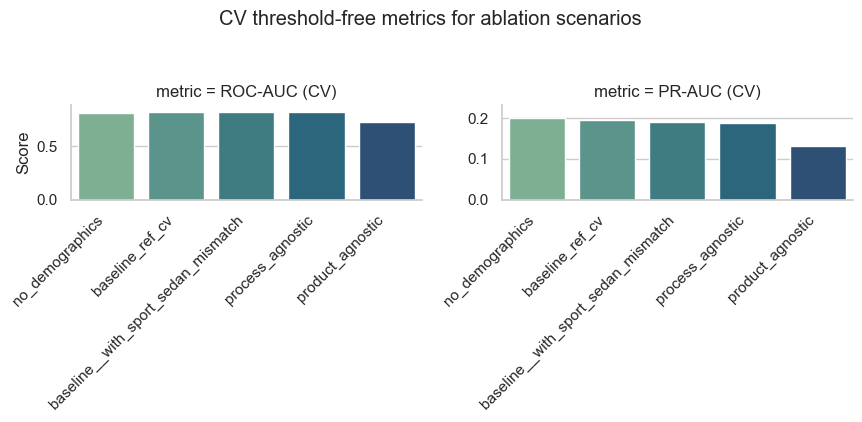

In [25]:
sns.set_theme(style="whitegrid")

# sorting
order = df_res.sort_values("pr_auc_mean", ascending=False)["variant"]

df_plot = df_res.melt(
    id_vars=["variant"],
    value_vars=["roc_auc_mean", "pr_auc_mean"],
    var_name="metric",
    value_name="score"
)

metric_labels = {
    "roc_auc_mean": "ROC-AUC (CV)",
    "pr_auc_mean": "PR-AUC (CV)",
}
df_plot["metric"] = df_plot["metric"].map(metric_labels)

g = sns.catplot(
    data=df_plot,
    x="variant",
    hue="variant",
    y="score",
    col="metric",
    kind="bar",
    sharey=False,
    height=4,
    aspect=1.1,
    order=order,
    palette="crest",
    legend=False
)

g.set_xticklabels(rotation=45, ha="right")
g.set_axis_labels("", "Score")

for ax in g.axes.flat:
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(max(0.0, ymin), min(1.0, ymax + 0.02))

g.fig.suptitle("CV threshold-free metrics for ablation scenarios", y=1.05)
plt.tight_layout()
plt.show()

### CV Ablation Results based on threshold-free metrics

We compare feature sets using **threshold-free CV metrics**:
- **ROC-AUC**: checks whether the model learns a meaningful ranking signal.
- **PR-AUC**: focuses on ranking quality for the **fraud (positive) class**, which is more informative under class imbalance.

**Key findings:**
- **Product-agnostic** (removing product/vehicle/policy structure features) causes a **large drop** in both ROC-AUC and PR-AUC -> product structure is a **major source of signal** in this dataset.
- **No demographics** performs **slightly better in PR-AUC** than the baseline → demographic features do **not** add a stable benefit and may add noise.
- **Process-agnostic** is **slightly worse in PR-AUC** than baseline -> workflow/process features provide a **small but positive** contribution.
- Adding **sport_sedan_mismatch** shows **no consistent improvement** -> not justified at this stage.

At this stage we use CV results to **select promising feature sets**. We will evaluate on the **held-out test year (1996)** only for the final candidates:
- Baseline (reference)
- No demographics (best PR-AUC + fewer features + lower bias risk)

In [26]:
# trying choosen set of features

def fit_eval_train_test(
    X_train_full: pd.DataFrame,
    y_train: pd.Series,
    X_test_full: pd.DataFrame,
    y_test: pd.Series,
    feature_list: list,
    variant_name: str,
):
    # 1) keep order, drop missing cols (safety)
    feats = _dedup_keep_order(feature_list)
    feats = [c for c in feats if c in X_train_full.columns]

    # 2) slice data
    Xtr = X_train_full[feats].copy()
    Xte = X_test_full[feats].copy()

    # 3) fit on train only
    pipe = build_model_pipeline(Xtr)
    pipe.fit(Xtr, y_train)

    # 4) predict probabilities
    p_tr = pipe.predict_proba(Xtr)[:, 1]
    p_te = pipe.predict_proba(Xte)[:, 1]

    # 5) threshold-free metrics
    out = {
        "variant": variant_name,
        "n_features_raw": len(feats),

        "train_roc_auc": roc_auc_score(y_train, p_tr),
        "train_pr_auc": average_precision_score(y_train, p_tr),

        "test_roc_auc": roc_auc_score(y_test, p_te),
        "test_pr_auc": average_precision_score(y_test, p_te),
    }
    return out


#  Candidate feature sets 
baseline_feats = _dedup_keep_order(BASELINE_FEATURES)
no_demo_feats  = _dedup_keep_order([c for c in BASELINE_FEATURES if c not in DEMOGRAPHICS])

#  evaluation 
rows = []
rows.append(fit_eval_train_test(X_train_full, y_train, X_test_full, y_test, baseline_feats, "baseline_reference"))
rows.append(fit_eval_train_test(X_train_full, y_train, X_test_full, y_test, no_demo_feats,  "no_demographics"))

df_tt = pd.DataFrame(rows)
df_tt = df_tt.sort_values("test_pr_auc", ascending=False)
df_tt.round(6)

,variant,n_features_raw,train_roc_auc,train_pr_auc,test_roc_auc,test_pr_auc
1,no_demographics,27,0.830685,0.233653,0.731557,0.093127
0,baseline_reference,32,0.831388,0.216338,0.731607,0.091753


In [27]:
# super Dumb baseline: always predicting prevalence

ap_dummy = average_precision_score(y_test, np.full_like(y_test, y_test.mean()))
ap_dummy

0.05216752387950037

In [28]:
print("Train size:", len(y_train), "Fraud rate:", y_train.mean())
print("Test size:", len(y_test), "Fraud rate:", y_test.mean())

# share of unseen categories in test (rough check)
cat_cols = [c for c in X_train_full.columns if X_train_full[c].dtype == "object"]
for c in cat_cols[:10]:
    unseen = set(X_test_full[c].dropna().unique()) - set(X_train_full[c].dropna().unique())
    if len(unseen) > 0:
        print(c, "unseen in test:", len(unseen))

Train size: 11336 Fraud rate: 0.06263232180663374
Test size: 4083 Fraud rate: 0.05216752387950037


In [29]:
def fit_eval_by_year(train_years, test_year, features):
    tr = X["Year"].isin(train_years)
    te = X["Year"] == test_year

    Xtr = X.loc[tr, features].copy()
    ytr = y.loc[tr].copy()
    Xte = X.loc[te, features].copy()
    yte = y.loc[te].copy()

    pipe = build_model_pipeline(Xtr)
    pipe.fit(Xtr, ytr)

    p_te = pipe.predict_proba(Xte)[:, 1]
    return {
        "train_years": str(train_years),
        "test_year": test_year,
        "test_roc_auc": roc_auc_score(yte, p_te),
        "test_pr_auc": average_precision_score(yte, p_te),
        "test_fraud_rate": yte.mean(),
        "test_n": len(yte)
    }

features_final = no_demo_feats  # или baseline_feats

rows = []
rows.append(fit_eval_by_year([1994], 1995, features_final))
rows.append(fit_eval_by_year([1994, 1995], 1996, features_final)) 

pd.DataFrame(rows).round(6)

,train_years,test_year,test_roc_auc,test_pr_auc,test_fraud_rate,test_n
0,[1994],1995,0.716303,0.104646,0.057940,5195
1,"[1994, 1995]",1996,0.731557,0.093127,0.052168,4083


In [30]:
features_used = no_demo_feats
features_used = [c for c in features_used if c in X_train_full.columns]

cat_cols_used = [c for c in features_used if X_train_full[c].dtype == "object"]

unseen_report = []
for c in cat_cols_used:
    train_cats = set(X_train_full[c].dropna().unique())
    test_cats  = set(X_test_full[c].dropna().unique())
    unseen_report.append({
        "col": c,
        "n_unseen_in_test": len(test_cats - train_cats)
    })

pd.DataFrame(unseen_report).sort_values("n_unseen_in_test", ascending=False)

,col,n_unseen_in_test
0,Month,0
1,DayOfWeek,0
20,CoverageType,0
19,VehicleGroup,0
18,NumberOfCars,0
17,NumberOfSuppliments,0
16,AgentType,0
15,WitnessPresent,0
14,PoliceReportFiled,0
13,AgeOfVehicle,0


### What we observed (metrics recap)

- Our **shuffled StratifiedKFold CV** on the train period (1994–1995) looked too **optimistic**.
- When we evaluate **out-of-time** (train on 1994 → test on 1995, and train on 1994–1995 → test on 1996), performance drops to a more realistic level:
- **PR-AUC ≈ 0.095–0.101** on 1995/1996, compared to the **dummy AP ≈ fraud rate (~0.052)**.
- This means the model still provides a **meaningful lift (~1.8–1.9× over random)**, but generalization across years is harder than CV suggested.
- We checked for **unseen categories** in 1996 and found **none**, so the drop is not explained by categorical novelty (and `OneHotEncoder(handle_unknown="ignore")` is not “hiding” new categories here).

### Hypotheses (why shuffled CV was too optimistic)

- **Temporal dependence / non-i.i.d. structure:** claims from adjacent periods may share patterns, and shuffled CV mixes 1994 and 1995 across folds, making validation too similar to training.
- **Concept and/or process drift (plausible):** even without new categories, the relationship between features and the fraud label may shift over time (e.g., different investigation practices, reporting behavior, or fraud strategies).
- **Labeling dynamics:** `FraudFound_P` may reflect insurer workflow decisions (confirmed vs suspected vs investigated), which can change year-to-year and affect predictability.

### What we will do next (planned evaluation protocol)

Because the goal is **next-year generalization**, we will switch feature-set selection from shuffled CV to a **time-aware validation**:

1) **Temporal ablation selection:** run the ablation comparisons using  
   - **train = 1994**, **validation = 1995** (model/feature selection)  
2) **Final confirmation:** retrain on **1994–1995** and evaluate once on the held-out **1996** test year.
3) Keep using **threshold-free metrics (ROC-AUC, PR-AUC)** during selection; threshold-based metrics (e.g., recall) will be introduced only after the final candidate feature set is chosen.

This ensures our ablation conclusions reflect the real deployment setting: scoring fraud risk for a future year.

### Ablation test on time split

In [31]:
VAL_YEAR = 1995
TRAIN_YEARS = [1994]

def evaluate_time_split(
    X_all: pd.DataFrame,
    y_all: pd.Series,
    feature_list: list,
    train_years: list,
    val_year: int,
):
    # keep order + keep only existing cols
    feats = _dedup_keep_order(feature_list)
    feats = [c for c in feats if c in X_all.columns]

    tr = X_all["Year"].isin(train_years)
    va = X_all["Year"] == val_year

    Xtr, ytr = X_all.loc[tr, feats].copy(), y_all.loc[tr].copy()
    Xva, yva = X_all.loc[va, feats].copy(), y_all.loc[va].copy()

    pipe = build_model_pipeline(Xtr)
    pipe.fit(Xtr, ytr)

    pva = pipe.predict_proba(Xva)[:, 1]

    val_roc = roc_auc_score(yva, pva)
    val_pr  = average_precision_score(yva, pva)
    dummy_ap = yva.mean()
    lift = val_pr / dummy_ap if dummy_ap > 0 else None

    return {
        "variant": None, 
        "train_years": str(train_years),
        "val_year": val_year,
        "val_roc_auc": val_roc,
        "val_pr_auc": val_pr,
        "val_ap_dummy": dummy_ap,
        "val_lift_vs_dummy": lift,
        "n_features_raw": len(feats),
        "val_n": len(yva),
        "val_fraud_rate": dummy_ap,
    }

results_time = []

def run_variant_time(name, feats):
    row = evaluate_time_split(X, y, feats, TRAIN_YEARS, VAL_YEAR)
    row["variant"] = name
    results_time.append(row)

# feature sets (we dont test ablation on product features as it's clear from last test its key important features)
run_variant_time("baseline_reference", BASELINE_FEATURES)

run_variant_time(
    "no_demographics",
    [c for c in BASELINE_FEATURES if c not in DEMOGRAPHICS]
)

run_variant_time(
    "process_agnostic",
    [c for c in BASELINE_FEATURES if c not in PROCESS_WORKFLOW]
)


run_variant_time("baseline__with_sport_sedan_mismatch",
            BASELINE_FEATURES + ["sport_sedan_mismatch"])

df_time = pd.DataFrame(results_time).sort_values("val_pr_auc", ascending=False)
df_time.round(6)

,variant,train_years,val_year,val_roc_auc,val_pr_auc,val_ap_dummy,val_lift_vs_dummy,n_features_raw,val_n,val_fraud_rate
1,no_demographics,[1994],1995,0.716303,0.104646,0.05794,1.806105,27,5195,0.05794
0,baseline_reference,[1994],1995,0.716965,0.102342,0.05794,1.766334,32,5195,0.05794
3,baseline__with_sport_sedan_mismatch,[1994],1995,0.715455,0.101909,0.05794,1.758862,33,5195,0.05794
2,process_agnostic,[1994],1995,0.717467,0.100448,0.05794,1.733649,25,5195,0.05794


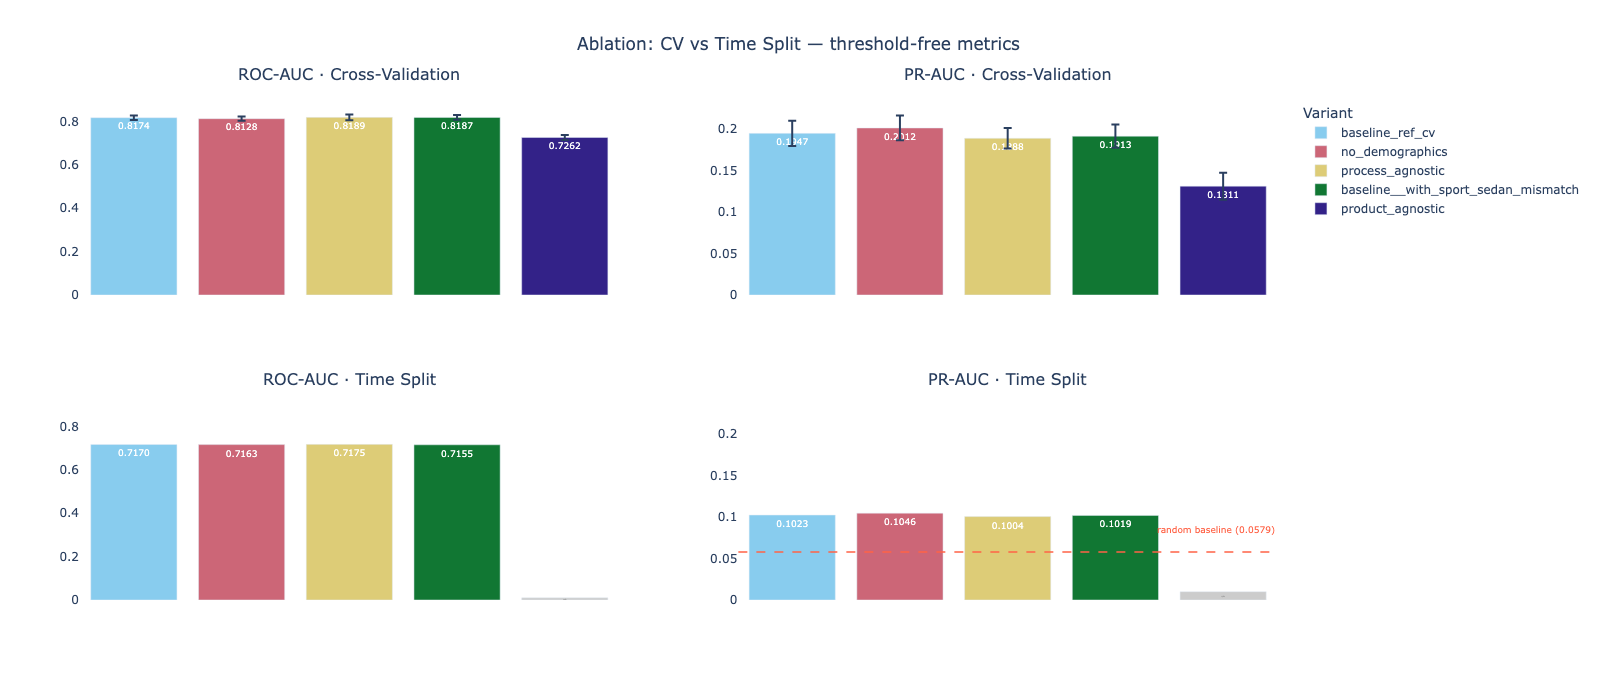

In [32]:
# visual for all ablation tests

fixed_order = [
    "baseline_ref_cv",
    "no_demographics",
    "process_agnostic",
    "baseline__with_sport_sedan_mismatch",
    "product_agnostic",
]

time_order = [
    "baseline_reference",
    "no_demographics",
    "process_agnostic",
    "baseline__with_sport_sedan_mismatch",
]

colors = ["#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288"]

color_map_cv = {v: colors[i] for i, v in enumerate(fixed_order)}

# map time_order on same positions we put cv
time_to_cv_idx = {
    "baseline_reference":                   0,  # = baseline_ref_cv
    "no_demographics":                      1,
    "process_agnostic":                     2,
    "baseline__with_sport_sedan_mismatch":  3,
}
color_map_time = {v: colors[i] for v, i in time_to_cv_idx.items()}


# same Y-range for same metrics
roc_max = max(
    df_res["roc_auc_mean"].max() + df_res["roc_auc_std"].max(),
    df_time["val_roc_auc"].max()
) * 1.08

pr_max = max(
    df_res["pr_auc_mean"].max() + df_res["pr_auc_std"].max(),
    df_time["val_pr_auc"].max()
) * 1.08

# dummy AP fr baseline
val_ap_dummy = 0.05794

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "ROC-AUC · Cross-Validation",  "PR-AUC · Cross-Validation",
        "ROC-AUC · Time Split",         "PR-AUC · Time Split",
    ],
    shared_xaxes=False,
    vertical_spacing=0.22,
    horizontal_spacing=0.1,
)

# helper: add bars for one subplot
def add_bars(df, x_col, y_col, err_col, order, cmap, row, col, show_legend):
    df_sorted = df.set_index(x_col).reindex(order).reset_index().dropna(subset=[y_col])
    for i, r in df_sorted.iterrows():
        variant = r[x_col]
        score   = r[y_col]
        err     = r[err_col] if err_col and err_col in df.columns else None
        fig.add_trace(
            go.Bar(
                x=[variant],
                y=[score],
                name=variant,
                marker_color=cmap.get(variant, "#aaaaaa"),
                text=[f"{score:.4f}"],
                textposition="inside",
                textfont=dict(color="white", size=9),
                error_y=dict(type="data", array=[err], visible=True) if err else None,
                hovertemplate=f"<b>{variant}</b><br>Score: {score:.4f}"
                              + (f"±{err:.4f}" if err else "") + "<extra></extra>",
                showlegend=show_legend,
            ),
            row=row, col=col
        )

# product_agnostic placeholder
def add_not_evaluated(row, col):
    fig.add_trace(
        go.Bar(
            x=["product_agnostic"],
            y=[0.01],
            name="product_agnostic",
            marker_color="#cccccc",
            text=["n/e"],
            textposition="inside",
            textfont=dict(color="#666666", size=9),
            hovertemplate="<b>product_agnostic</b><br>Not evaluated on time-split<extra></extra>",
            showlegend=False,
        ),
        row=row, col=col
    )

# 4 panels
add_bars(df_res,  "variant", "roc_auc_mean", "roc_auc_std", fixed_order, color_map_cv,   1, 1, show_legend=True)
add_bars(df_res,  "variant", "pr_auc_mean",  "pr_auc_std",  fixed_order, color_map_cv,   1, 2, show_legend=False)
add_bars(df_time, "variant", "val_roc_auc",  None,          time_order,  color_map_time, 2, 1, show_legend=False)
add_bars(df_time, "variant", "val_pr_auc",   None,          time_order,  color_map_time, 2, 2, show_legend=False)

# placeholders for product_agnostic
add_not_evaluated(row=2, col=1)
add_not_evaluated(row=2, col=2)

# line dummy AP на PR-AUC Time Split
fig.add_hline(
    y=val_ap_dummy,
    row=2, col=2,
    line_dash="dash",
    line_color="tomato",
    line_width=1.5,
    annotation_text=f"random baseline ({val_ap_dummy:.4f})",
    annotation_position="top right",
    annotation_font=dict(size=9, color="tomato"),
)

# same Y-ranges for one metric
fig.update_yaxes(range=[0, roc_max], row=1, col=1)
fig.update_yaxes(range=[0, roc_max], row=2, col=1)
fig.update_yaxes(range=[0, pr_max],  row=1, col=2)
fig.update_yaxes(range=[0, pr_max],  row=2, col=2)

fig.update_layout(
    title_text="Ablation: CV vs Time Split — threshold-free metrics",
    title_x=0.5,
    height=680,
    barmode="group",
    legend=dict(title="Variant", orientation="v", x=1.02, y=1.0),
    plot_bgcolor="white",
    paper_bgcolor="white",
)

fig.update_xaxes(showticklabels=False)
fig.update_annotations(yshift=+15)
fig.show()

### Ablation summary

We evaluated feature-set variants with two protocols:

1) **Shuffled Stratified CV (1994–1995)** — optimistic, i.i.d.-style estimate  
2) **Time split (1994 → 1995)** — realistic next-year generalization check


- Under **shuffled CV**, `no_demographics` looked slightly best in PR-AUC, and `product_agnostic` collapsed -> product/policy/vehicle structure carries strong signal.
- Under the **time split**, the ranking changes: **`baseline_reference` (all features)** performs best on PR-AUC, while `no_demographics`, `process_agnostic`, and `sport_sedan_mismatch` are slightly worse.
- All time-split models beat the **random baseline AP ≈ prevalence** (PR-AUC lift ≈ 1.7–1.8×), but the gap between variants is small.

**Why CV vs time split differ:**
- Shuffled CV mixes years within folds, so validation is closer to training distribution and may **overestimate** performance for temporal generalization.
- Time split better matches the deployment framing (“score future claims”), revealing a **temporal generalization gap**.

**Decision:**
- For a realistic next-year setting, we select **`baseline_reference` (all features)** as the final feature set.
- `no_demographics` remains an interesting alternative for bias-risk reduction, but it does not win under time-split validation.

Note: Ablation experiments were conducted without feature scaling and based on relative comparisons under a fixed pipeline; StandardScaler will be added to the final pipeline prior to sampling experiments.

**Next steps**
- Keep the chosen feature set fixed and improve the model via:
  1) class imbalance handling (weights / under- / oversampling),
  2) one stronger non-linear model (tree boosting) under the same temporal protocol,
  3) business-oriented ranking evaluation (e.g., Recall@TopK / Precision@TopK).

## <a id="logistic-regression-imbalance-strategies"></a>Logistic Regression: Imbalance Strategies

**Plan**:
1. Reference: LogReg + class_weight="balanced" (no resampling)
2. Over-sampling sweep: `RandomOverSampler` ratios = 0.10, 0.20, 0.33
3. Under-sampling sweep: `RandomUnderSampler` ratios = 0.10, 0.20
4. Select top-1/top-2 based on val PR-AUC (1995)
5. Final check for test 1996 (only for top-1/2)

**Metrics for selection**: PR-AUC (primary), ROC-AUC (secondary).
Train metrics are considered only as a sanity check for overfitting (especially for oversampling), but decisions are calculated based on val.

In [33]:
# settings

SEED = 42
FEATURES = BASELINE_FEATURES  # we choose this feature set after ablation (all features + lag_bin_2)

TRAIN_YEAR_FOR_VAL = 1994
VAL_YEAR = 1995

TRAIN_YEARS_FOR_TEST = [1994, 1995]
TEST_YEAR = 1996

OVER_RATIOS  = [0.10, 0.20, 0.33]  
UNDER_RATIOS = [0.10, 0.20]        

DEFAULT_RATIO = 0.20

In [34]:
def build_preprocessor(X_subset: pd.DataFrame) -> ColumnTransformer:
    numeric_cols = X_subset.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in X_subset.columns if c not in numeric_cols]

    numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop"
    )

In [35]:
def build_logreg_pipeline(X_subset: pd.DataFrame, sampler=None, class_weight=None):
    
    """
    Pipeline for Logistic Regression with optional resampling.
    Resampling happens AFTER preprocessing (after OHE), which is safe for RandomOver/Under.
    """
    
    preprocessor = build_preprocessor(X_subset)

    clf = LogisticRegression(
        max_iter=3000,
        solver="liblinear",
        class_weight=class_weight
    )

    if sampler is None:
        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", clf),
        ])
    else:
        pipe = ImbPipeline(steps=[
            ("preprocess", preprocessor),
            ("resample", sampler),
            ("model", clf),
        ])
    return pipe

In [36]:
def eval_year_split(train_years, eval_year, features, sampler=None, class_weight=None, name=""):
    
    # ensure features exist and keep stable order
    feats = _dedup_keep_order([c for c in features if c in X.columns])

    tr = X["Year"].isin(train_years)
    ev = X["Year"] == eval_year

    Xtr, ytr = X.loc[tr, feats].copy(), y.loc[tr].copy()
    Xev, yev = X.loc[ev, feats].copy(), y.loc[ev].copy()

    pipe = build_logreg_pipeline(Xtr, sampler=sampler, class_weight=class_weight)
    pipe.fit(Xtr, ytr)

    # probabilities on ORIGINAL (not-resampled) train/eval
    ptr = pipe.predict_proba(Xtr)[:, 1]
    pev = pipe.predict_proba(Xev)[:, 1]

    out = {
        "variant": name,
        "train_years": str(train_years),
        "eval_year": eval_year,
        "n_features_raw": len(feats),

        "train_roc_auc": roc_auc_score(ytr, ptr),
        "train_pr_auc": average_precision_score(ytr, ptr),

        "eval_roc_auc": roc_auc_score(yev, pev),
        "eval_pr_auc": average_precision_score(yev, pev),

        "eval_ap_dummy": yev.mean(),
        "eval_lift_vs_dummy": average_precision_score(yev, pev) / yev.mean() if yev.mean() > 0 else None,

        "eval_n": len(yev),
        "eval_fraud_rate": yev.mean(),
    }
    return out

In [37]:
# Time-split selection: 1994 -> 1995

rows_val = []

# Reference: class_weight balanced, no resampling
rows_val.append(
    eval_year_split(
        train_years=[TRAIN_YEAR_FOR_VAL],
        eval_year=VAL_YEAR,
        features=FEATURES,
        sampler=None,
        class_weight="balanced",
        name="ref_balanced_weights"
    )
)

# Over-sampling sweep (no class_weight to keep mechanisms separated)
for r in OVER_RATIOS:
    sampler = RandomOverSampler(sampling_strategy=r, random_state=SEED)
    rows_val.append(
        eval_year_split(
            train_years=[TRAIN_YEAR_FOR_VAL],
            eval_year=VAL_YEAR,
            features=FEATURES,
            sampler=sampler,
            class_weight=None,
            name=f"over_{r:.2f}"
        )
    )

# Under-sampling sweep
for r in UNDER_RATIOS:
    sampler = RandomUnderSampler(sampling_strategy=r, random_state=SEED)
    rows_val.append(
        eval_year_split(
            train_years=[TRAIN_YEAR_FOR_VAL],
            eval_year=VAL_YEAR,
            features=FEATURES,
            sampler=sampler,
            class_weight=None,
            name=f"under_{r:.2f}"
        )
    )

df_val = pd.DataFrame(rows_val).sort_values("eval_pr_auc", ascending=False)
df_val.round(6)

,variant,train_years,eval_year,n_features_raw,train_roc_auc,train_pr_auc,eval_roc_auc,eval_pr_auc,eval_ap_dummy,eval_lift_vs_dummy,eval_n,eval_fraud_rate
4,under_0.10,[1994],1995,32,0.882082,0.314559,0.710824,0.103700,0.05794,1.789774,5195,0.05794
3,over_0.33,[1994],1995,32,0.886389,0.300964,0.701931,0.103254,0.05794,1.782068,5195,0.05794
0,ref_balanced_weights,[1994],1995,32,0.888026,0.284302,0.700585,0.102517,0.05794,1.769360,5195,0.05794
5,under_0.20,[1994],1995,32,0.881328,0.298447,0.709328,0.101946,0.05794,1.759497,5195,0.05794
2,over_0.20,[1994],1995,32,0.883759,0.307514,0.705542,0.101537,0.05794,1.752450,5195,0.05794
1,over_0.10,[1994],1995,32,0.880956,0.310905,0.691229,0.096848,0.05794,1.671519,5195,0.05794


In [38]:
# pick top-2 by validation PR-AUC (1995)

top2 = df_val.sort_values("eval_pr_auc", ascending=False).head(2)["variant"].tolist()
top2

['under_0.10', 'over_0.33']

In [39]:
# top2 on test 1996 y

def make_sampler_from_name(name: str):
    if name == "ref_balanced_weights":
        return None, "balanced"
    if name.startswith("over_"):
        r = float(name.split("_")[1])
        return RandomOverSampler(sampling_strategy=r, random_state=SEED), None
    if name.startswith("under_"):
        r = float(name.split("_")[1])
        return RandomUnderSampler(sampling_strategy=r, random_state=SEED), None
    raise ValueError(f"Unknown variant name: {name}")

rows_test = []

for name in top2:
    sampler, cw = make_sampler_from_name(name)
    rows_test.append(
        eval_year_split(
            train_years=TRAIN_YEARS_FOR_TEST,
            eval_year=TEST_YEAR,
            features=FEATURES,
            sampler=sampler,
            class_weight=cw,
            name=name
        )
    )

df_test = pd.DataFrame(rows_test).sort_values("eval_pr_auc", ascending=False)
df_test.round(6)

,variant,train_years,eval_year,n_features_raw,train_roc_auc,train_pr_auc,eval_roc_auc,eval_pr_auc,eval_ap_dummy,eval_lift_vs_dummy,eval_n,eval_fraud_rate
1,over_0.33,"[1994, 1995]",1996,32,0.846688,0.213992,0.738294,0.099669,0.052168,1.910564,4083,0.052168
0,under_0.10,"[1994, 1995]",1996,32,0.843215,0.221073,0.737729,0.098723,0.052168,1.892426,4083,0.052168


### SMOTENC

We include SMOTENC as a commonly recommended technique for minority class imbalance. Because our dataset contains categorical features, we use SMOTENC (not standard SMOTE) and apply it before one-hot encoding.

It is important to use SMOTENC before OHE so we use separate pipeline!

In [40]:
SEED = 42

# Helpers: feature typing

def get_num_cat_cols(X_subset: pd.DataFrame):
    """
    Define numeric vs categorical based on dtypes in X_subset.
    Categorical = everything that's not numeric/bool.
    """
    numeric_cols = X_subset.select_dtypes(include=["number", "bool"]).columns.tolist()
    categorical_cols = [c for c in X_subset.columns if c not in numeric_cols]
    return numeric_cols, categorical_cols

In [41]:
# Build SMOTENC pipeline: impute -> SMOTENC -> OHE -> scale num -> logreg

def build_smote_nc_pipeline(X_subset: pd.DataFrame, sampling_strategy: float, k_neighbors: int):
    
    """
    SMOTENC must run BEFORE OHE and needs indices of categorical columns.
    We'll:
      1) Impute numeric/cat (no OHE yet)
      2) Apply SMOTENC on the imputed raw columns
      3) Apply ColumnTransformer with OHE for cat + scaler for num
      4) Train Logistic Regression
    """
    
    numeric_cols, categorical_cols = get_num_cat_cols(X_subset)

    # Step 1: impute without changing column order (cat+num remain as columns)
    impute_num = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    impute_cat = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ])

    pre_impute = ColumnTransformer(
        transformers=[
            ("num", impute_num, numeric_cols),
            ("cat", impute_cat, categorical_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    ).set_output(transform="pandas")  # keep as DataFrame to preserve column names/order

    # categorical indices for SMOTENC (after pre_impute, columns order = numeric_cols + categorical_cols)
    # Because ColumnTransformer outputs in the order transformers are listed.
    cat_indices = list(range(len(numeric_cols), len(numeric_cols) + len(categorical_cols)))

    smote = SMOTENC(
        categorical_features=cat_indices,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors,
        random_state=SEED
    )

    # Step 3: final encoding/scaling after resampling
    post_num = Pipeline(steps=[
        ("scaler", StandardScaler()),
    ])
    post_cat = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    post_preprocess = ColumnTransformer(
        transformers=[
            ("num", post_num, numeric_cols),
            ("cat", post_cat, categorical_cols),
        ],
        remainder="drop"
    )

    clf = LogisticRegression(
        max_iter=3000,
        solver="liblinear",
        class_weight="balanced"  # keep consistent with our baseline setup
    )

    pipe = ImbPipeline(steps=[
        ("pre_impute", pre_impute),
        ("smote", smote),
        ("post_preprocess", post_preprocess),
        ("model", clf),
    ])
    return pipe

In [42]:
# Evaluation: time split

def eval_time_split_smote(train_years, eval_year, features, sampling_strategy, k_neighbors, name):
    feats = _dedup_keep_order([c for c in features if c in X.columns])

    tr = X["Year"].isin(train_years)
    ev = X["Year"] == eval_year

    Xtr, ytr = X.loc[tr, feats].copy(), y.loc[tr].copy()
    Xev, yev = X.loc[ev, feats].copy(), y.loc[ev].copy()

    pipe = build_smote_nc_pipeline(Xtr, sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
    pipe.fit(Xtr, ytr)

    pev = pipe.predict_proba(Xev)[:, 1]

    pr = average_precision_score(yev, pev)
    roc = roc_auc_score(yev, pev)
    dummy = float(yev.mean())

    return {
        "variant": name,
        "train_years": str(train_years),
        "eval_year": eval_year,
        "sampling_strategy": sampling_strategy,
        "k_neighbors": k_neighbors,
        "eval_roc_auc": roc,
        "eval_pr_auc": pr,
        "eval_ap_dummy": dummy,
        "eval_lift_vs_dummy": pr / dummy if dummy > 0 else np.nan,
        "eval_n": len(yev),
        "eval_fraud_rate": dummy,
        "n_features_raw": len(feats),
    }

In [43]:
# Run grid on VAL (1995): train 1994 -> val 1995

SMOTE_RATIOS = [0.10, 0.20, 0.33]
K_NEIGHBORS = [3, 5]

rows_smote_val = []
for r in SMOTE_RATIOS:
    for k in K_NEIGHBORS:
        name = f"smotenc_r{r:.2f}_k{k}"
        rows_smote_val.append(
            eval_time_split_smote(
                train_years=[1994],
                eval_year=1995,
                features=BASELINE_FEATURES,
                sampling_strategy=r,
                k_neighbors=k,
                name=name
            )
        )

df_smote_val = pd.DataFrame(rows_smote_val).sort_values("eval_pr_auc", ascending=False)
df_smote_val.round(6)

,variant,train_years,eval_year,sampling_strategy,k_neighbors,eval_roc_auc,eval_pr_auc,eval_ap_dummy,eval_lift_vs_dummy,eval_n,eval_fraud_rate,n_features_raw
3,smotenc_r0.20_k5,[1994],1995,0.20,5,0.717673,0.107958,0.05794,1.863270,5195,0.05794,32
4,smotenc_r0.33_k3,[1994],1995,0.33,3,0.713567,0.106508,0.05794,1.838235,5195,0.05794,32
5,smotenc_r0.33_k5,[1994],1995,0.33,5,0.712220,0.106376,0.05794,1.835959,5195,0.05794,32
1,smotenc_r0.10_k5,[1994],1995,0.10,5,0.717001,0.106283,0.05794,1.834350,5195,0.05794,32
0,smotenc_r0.10_k3,[1994],1995,0.10,3,0.710593,0.106106,0.05794,1.831300,5195,0.05794,32
2,smotenc_r0.20_k3,[1994],1995,0.20,3,0.712171,0.105655,0.05794,1.823513,5195,0.05794,32


In [44]:
# take top-1 on 1995 and check it on 1996!

best = df_smote_val.iloc[0]
best_ratio = float(best["sampling_strategy"])
best_k = int(best["k_neighbors"])

best_name = f"smotenc_r{best_ratio:.2f}_k{best_k}"

row_smote_test = eval_time_split_smote(
    train_years=[1994, 1995],
    eval_year=1996,
    features=BASELINE_FEATURES,
    sampling_strategy=best_ratio,
    k_neighbors=best_k,
    name=best_name
)

df_smote_test = pd.DataFrame([row_smote_test]).round(6)
df_smote_test

,variant,train_years,eval_year,sampling_strategy,k_neighbors,eval_roc_auc,eval_pr_auc,eval_ap_dummy,eval_lift_vs_dummy,eval_n,eval_fraud_rate,n_features_raw
0,smotenc_r0.20_k5,"[1994, 1995]",1996,0.2,5,0.731916,0.098546,0.052168,1.889036,4083,0.052168,32


### SMOTENC result 
Because the minority class is ~6% and the dataset contains many categorical variables, we evaluated **SMOTENC** (categorical-aware synthetic oversampling) as an additional imbalance strategy.

Using the temporal protocol, **SMOTENC (ratio=0.33, k=3)** achieved the best PR-AUC on both validation and test.  

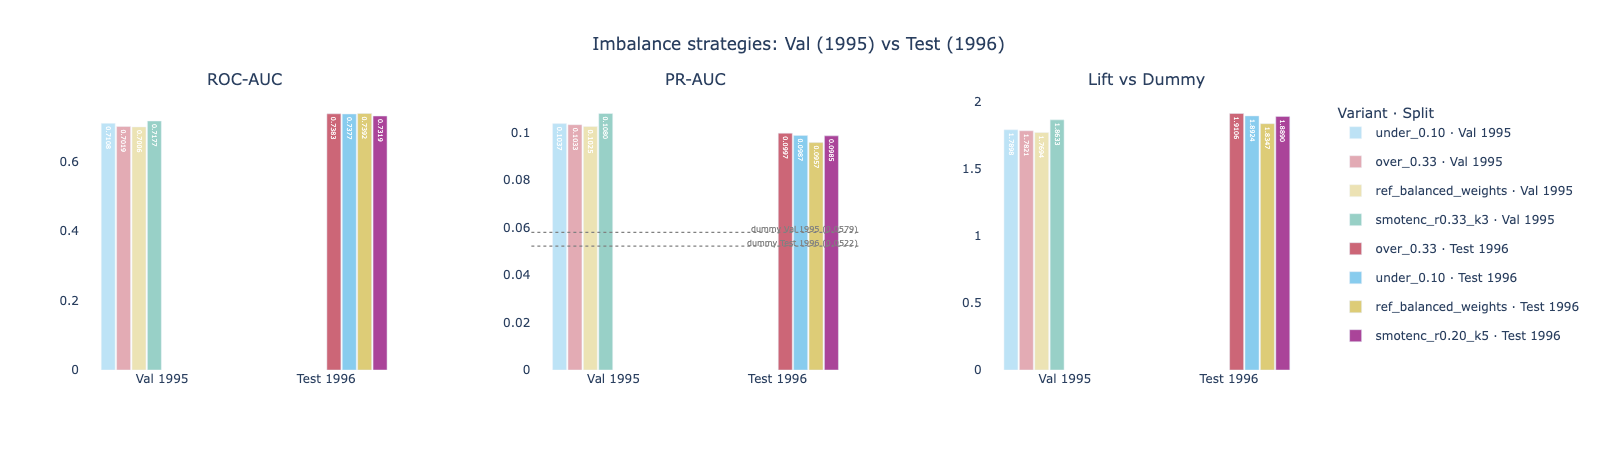

In [45]:
# final evaluation visual

top2 = ["under_0.10", "over_0.33"]
cols = ["variant", "split", "eval_roc_auc", "eval_pr_auc", "eval_lift_vs_dummy", "eval_ap_dummy"]

# val: top2 + ref_balanced + smotenc
top4 = top2 + ["ref_balanced_weights", "smotenc_r0.33_k3"]
df_val_top4 = df_val[df_val["variant"].isin(top2 + ["ref_balanced_weights"])].copy()
df_val_top4["split"] = "Val 1995"

# smotenc val row из df_smote_val
smote_val_row = df_smote_val.iloc[0][["eval_roc_auc", "eval_pr_auc", "eval_lift_vs_dummy", "eval_ap_dummy"]].to_dict()
smote_val_row["variant"] = "smotenc_r0.33_k3"
smote_val_row["split"]   = "Val 1995"
df_smote_val_row = pd.DataFrame([smote_val_row])

# test: top2 + ref_balanced + smotenc
df_test_plot = df_test.copy()
df_test_plot["split"] = "Test 1996"

rows_ref = [eval_year_split(
    train_years=TRAIN_YEARS_FOR_TEST,
    eval_year=TEST_YEAR,
    features=FEATURES,
    sampler=None,
    class_weight="balanced",
    name="ref_balanced_weights"
)]
df_test_ref = pd.DataFrame(rows_ref)
df_test_ref["split"] = "Test 1996"

df_smote_test_plot = df_smote_test.copy()
df_smote_test_plot["split"] = "Test 1996"

df_combined = pd.concat([
    df_val_top4[cols],
    df_smote_val_row[cols],
    df_test_plot[cols],
    df_test_ref[cols],
    df_smote_test_plot[cols],
], ignore_index=True)

# styling
variant_colors = {
    "under_0.10":           "#88CCEE",  
    "over_0.33":            "#CC6677",  
    "ref_balanced_weights": "#DDCC77",  
    "smotenc_r0.33_k3":     "#44AA99", 
    "smotenc_r0.20_k5":     "#AA4499",
}
split_opacity = {"Val 1995": 0.55, "Test 1996": 1.0}

metrics = [
    ("eval_roc_auc",        "ROC-AUC"),
    ("eval_pr_auc",         "PR-AUC"),
    ("eval_lift_vs_dummy",  "Lift vs Dummy"),
]

# plotttt
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[m[1] for m in metrics],
    horizontal_spacing=0.1,
)

shown_legends = set()

for col_idx, (metric_col, metric_name) in enumerate(metrics, start=1):
    for _, row in df_combined.iterrows():
        variant    = row["variant"]
        split      = row["split"]
        score      = row[metric_col]
        legend_key = (variant, split)

        fig.add_trace(
            go.Bar(
                x=[split],
                y=[score],
                name=f"{variant} · {split}",
                marker_color=variant_colors[variant],
                opacity=split_opacity[split],
                text=f"{score:.4f}",
                textposition="inside",
                textfont=dict(color="white", size=9),
                hovertemplate=(
                    f"<b>{variant}</b><br>"
                    f"Split: {split}<br>"
                    f"{metric_name}: {score:.4f}<br>"
                    + (f"Lift vs dummy: {row['eval_lift_vs_dummy']:.3f}×"
                       if metric_col != "eval_lift_vs_dummy" else "")
                    + "<extra></extra>"
                ),
                showlegend=(legend_key not in shown_legends and col_idx == 1),
                legendgroup=f"{variant}·{split}",
            ),
            row=1, col=col_idx,
        )
        shown_legends.add(legend_key)

# dummy AP line
for split_name, dummy_val in [("Val 1995", 0.05794), ("Test 1996", 0.052168)]:
    fig.add_hline(
        y=dummy_val, row=1, col=2,
        line_dash="dot", line_color="gray", line_width=1.2,
        annotation_text=f"dummy {split_name} ({dummy_val:.4f})",
        annotation_position="bottom right",
        annotation_font=dict(size=8, color="gray"),
    )

fig.update_layout(
    title_text="Imbalance strategies: Val (1995) vs Test (1996)",
    title_x=0.5,
    height=450,
    bargap=0.25,
    bargroupgap=0.09,
    barmode="group",
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(title="Variant · Split", x=1.02, y=1.0),
)
fig.update_yaxes(rangemode="tozero")
fig.update_annotations(yshift=+10)
fig.show()

### Final choice for Logistic Regression: Imbalance Strategies

**Selection metric:** We use **PR-AUC on the out-of-time validation year (1995)** as the primary criterion (ROC-AUC as secondary).  
This matches our goal: **next-year generalization** rather than i.i.d. performance.

#### Stage 1 — Standard imbalance handling (weights / over / under)
We first evaluated three common strategies:
- `ref_balanced_weights` (LogReg with `class_weight="balanced"`)
- random oversampling
- random undersampling

**Result:** These strategies produced **nearly identical** performance on Val 1995 and Test 1996 (differences were very small), suggesting that simple resampling did not provide a stable, meaningful improvement over class weights alone.

#### Stage 2 — Categorical-aware synthetic oversampling (SMOTENC)
Because the minority class is ~6% and the dataset contains many categorical variables, we additionally tested **SMOTENC** (synthetic oversampling designed for mixed numeric + categorical features, applied *before* one-hot encoding).

**Result:** **SMOTENC (sampling_strategy=0.33, k_neighbors=3)** achieved the best PR-AUC on **both**:
- **Val 1995** (train 1994 → val 1995), and
- **Test 1996** (train 1994–95 → test 1996),

indicating a **more consistent improvement** than standard over/under sampling.

#### Decision
- **Final model for downstream analysis:** `smotenc_r0.33_k3` (LogReg + SMOTENC)
- **Secondary baseline:** `ref_balanced_weights` (simplest strong baseline)

Next, we evaluate the selected model(s) using **Top-K prioritization metrics**, which better reflect real investigation workflows under limited capacity.

## <a id="top-k-metrics-fraud-prioritization"></a>Top-K Metrics - Fraud Prioritization

In real insurance workflows, fraud models are rarely used to **auto-approve/deny** claims based on a fixed probability threshold.  
Instead, the model produces a **risk score** and the business uses it to **prioritize** a limited number of cases for human investigation.

Because investigation capacity is constrained (time, budget, staff), the practical question is:

> *“If we can review only the top K% highest-risk claims, how much fraud will we catch, and how efficient is that queue?”*

Therefore, we evaluate **ranking-based Top-K metrics** on the held-out year (1996), with a small sanity check on 1995:

- **Precision@K**: among the top K% flagged for investigation, what fraction are actually fraud?
- **Recall@K**: what fraction of all fraud cases are captured within the top K%?
- **Lift@K**: how much more concentrated fraud is in the top K% compared to random selection (Precision@K / base fraud rate).

We report these metrics for multiple K values (e.g., 1%, 5%, 10%, 20%) to reflect different investigation capacities.  
This makes the evaluation directly actionable and avoids arbitrary threshold choices that a confusion matrix would require.

In [46]:
K_LIST = [0.01, 0.05, 0.10, 0.20]  # 1%, 5%, 10%, 20%


def topk_metrics(
    y_true: pd.Series,
    y_score: np.ndarray,
    k_list=(0.01, 0.05, 0.10, 0.20),
) -> pd.DataFrame:

    y_true = pd.Series(y_true).astype(int).reset_index(drop=True)
    y_score = np.asarray(y_score)

    n = len(y_true)
    pos_total = int(y_true.sum())
    prevalence = pos_total / n if n else np.nan
    order = np.argsort(-y_score)

    rows = []
    for k in k_list:
        m = max(1, int(np.ceil(k * n)))
        top_idx = order[:m]
        y_top = y_true.iloc[top_idx]

        tp = int((y_top == 1).sum())
        fp = int((y_top == 0).sum())
        fn_outside = pos_total - tp

        rows.append({
            "K": k,
            "K_pct": f"{int(k*100)}%",
            "N_total": n,
            "Pos_total": pos_total,
            "N_investigated": m,
            "TP_in_topK": tp, # real fraud cases
            "FP_in_topK": fp, # how much legit cases checked
            "FN_missed_outside_topK": fn_outside, #fraud missed
            "Precision_at_K": tp / m,
            "Recall_at_K": tp / pos_total if pos_total > 0 else np.nan,
            "Lift_at_K": (tp / m) / prevalence if prevalence > 0 else np.nan,
            "Investigations_per_fraud": m / tp if tp > 0 else np.inf,
             "Prevalence": prevalence
        })

    return pd.DataFrame(rows)

In [47]:
def fit_score_year_split(train_years, eval_year, features, class_weight="balanced"):
    
    """
    Fit on train_years and return scores on eval_year + basic threshold-free metrics.
    Uses your preprocessing pipeline.
    """
    
    feats = _dedup_keep_order([c for c in features if c in X.columns])

    tr = X["Year"].isin(train_years)
    ev = X["Year"] == eval_year

    Xtr, ytr = X.loc[tr, feats].copy(), y.loc[tr].copy()
    Xev, yev = X.loc[ev, feats].copy(), y.loc[ev].copy()

    # Build model: Logistic Regression with balanced class weights (no resampling here)
    # If you still have build_model_pipeline(X_subset) hardcoded without class_weight,
    # use build_logreg_pipeline (from our imbalance section) instead:
    pipe = build_logreg_pipeline(Xtr, sampler=None, class_weight=class_weight)

    pipe.fit(Xtr, ytr)
    sev = pipe.predict_proba(Xev)[:, 1]

    # threshold-free metrics for context (optional)
    out = {
        "eval_year": eval_year,
        "train_years": str(train_years),
        "eval_roc_auc": roc_auc_score(yev, sev),
        "eval_pr_auc": average_precision_score(yev, sev),
        "eval_ap_dummy": float(yev.mean()),
        "eval_lift_vs_dummy": float(average_precision_score(yev, sev) / yev.mean()) if yev.mean() > 0 else np.nan,
        "eval_n": len(yev),
        "eval_fraud_rate": float(yev.mean()),
        "scores": sev,
        "y_true": yev.reset_index(drop=True),
    }
    return out

In [48]:
# Run Top-K evaluation

FEATURES_FINAL = BASELINE_FEATURES  # since we chose baseline_reference feature set

# Main: train 1994–1995 -> test 1996
res_1996 = fit_score_year_split([1994, 1995], 1996, FEATURES_FINAL, class_weight="balanced")
topk_1996 = topk_metrics(res_1996["y_true"], res_1996["scores"], K_LIST)
topk_1996.insert(0, "split", "TEST 1996 (train 1994-95)")

# Sanity: train 1994 -> val 1995
res_1995 = fit_score_year_split([1994], 1995, FEATURES_FINAL, class_weight="balanced")
topk_1995 = topk_metrics(res_1995["y_true"], res_1995["scores"], K_LIST)
topk_1995.insert(0, "split", "SANITY 1995 (train 1994)")

# Combine for a compact view
df_topk = pd.concat([topk_1996, topk_1995], ignore_index=True)

# Pretty display
cols_show = [
    "split", "K_pct",
    "N_investigated", "TP_in_topK", "FP_in_topK",
    "Precision_at_K", "Recall_at_K", "FN_missed_outside_topK", "Lift_at_K",
    "Prevalence",
]
df_topk[cols_show].round(4)

,split,K_pct,N_investigated,TP_in_topK,FP_in_topK,Precision_at_K,Recall_at_K,FN_missed_outside_topK,Lift_at_K,Prevalence
0,TEST 1996 (train 1994-95),1%,41,6,35,0.1463,0.0282,207,2.8052,0.0522
1,TEST 1996 (train 1994-95),5%,205,14,191,0.0683,0.0657,199,1.3091,0.0522
2,TEST 1996 (train 1994-95),10%,409,31,378,0.0758,0.1455,182,1.4529,0.0522
3,TEST 1996 (train 1994-95),20%,817,71,746,0.0869,0.3333,142,1.6659,0.0522
4,SANITY 1995 (train 1994),1%,52,5,47,0.0962,0.0166,296,1.6595,0.0579
5,SANITY 1995 (train 1994),5%,260,29,231,0.1115,0.0963,272,1.9251,0.0579
6,SANITY 1995 (train 1994),10%,520,58,462,0.1115,0.1927,243,1.9251,0.0579
7,SANITY 1995 (train 1994),20%,1039,113,926,0.1088,0.3754,188,1.8771,0.0579


In [49]:
pd.DataFrame([
    {k: v for k, v in res_1996.items() if k not in ["scores", "y_true"]},
    {k: v for k, v in res_1995.items() if k not in ["scores", "y_true"]},
]).round(6)

,eval_year,train_years,eval_roc_auc,eval_pr_auc,eval_ap_dummy,eval_lift_vs_dummy,eval_n,eval_fraud_rate
0,1996,"[1994, 1995]",0.739190,0.095711,0.052168,1.834693,4083,0.052168
1,1995,[1994],0.700585,0.102517,0.057940,1.769360,5195,0.057940


In [50]:
# SMOTENC Top_K test

# SMOTENC winner params
SMOTE_RATIO = 0.33
SMOTE_K = 3

def fit_score_year_split_smotenc(train_years, eval_year, features, sampling_strategy=SMOTE_RATIO, k_neighbors=SMOTE_K):
    feats = _dedup_keep_order([c for c in features if c in X.columns])

    tr = X["Year"].isin(train_years)
    ev = X["Year"] == eval_year

    Xtr, ytr = X.loc[tr, feats].copy(), y.loc[tr].copy()
    Xev, yev = X.loc[ev, feats].copy(), y.loc[ev].copy()

    pipe = build_smote_nc_pipeline(
        Xtr,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors
    )
    pipe.fit(Xtr, ytr)

    sev = pipe.predict_proba(Xev)[:, 1]

    return {
        "eval_year": eval_year,
        "train_years": str(train_years),
        "eval_roc_auc": roc_auc_score(yev, sev),
        "eval_pr_auc": average_precision_score(yev, sev),
        "eval_ap_dummy": float(yev.mean()),
        "eval_lift_vs_dummy": float(average_precision_score(yev, sev) / yev.mean()) if yev.mean() > 0 else np.nan,
        "eval_n": len(yev),
        "eval_fraud_rate": float(yev.mean()),
        "scores": sev,
        "y_true": yev.reset_index(drop=True),
    }

# get scores for 1996 + sanity 1995
res96_smote = fit_score_year_split_smotenc([1994, 1995], 1996, BASELINE_FEATURES)
res95_smote = fit_score_year_split_smotenc([1994], 1995, BASELINE_FEATURES)


topk96_smote = topk_metrics(
    res96_smote["y_true"], res96_smote["scores"],
    k_list=K_LIST)
topk96_smote.insert(0, "model", "SMOTENC r0.33 k3")
topk96_smote.insert(1, "split", "TEST 1996 (train 1994-95)")

topk95_smote = topk_metrics(
    res95_smote["y_true"], res95_smote["scores"],
    k_list=K_LIST)
topk95_smote.insert(0, "model", "SMOTENC r0.33 k3")
topk95_smote.insert(1, "split", "SANITY 1995 (train 1994)")

df_topk_smote = pd.concat([topk96_smote, topk95_smote], ignore_index=True)

cols_show = [
    "model","split","K_pct",
    "N_investigated","TP_in_topK","FP_in_topK","FN_missed_outside_topK",
    "Precision_at_K","Recall_at_K","Lift_at_K","Prevalence"
]
df_topk_smote[cols_show].round(4)

,model,split,K_pct,N_investigated,TP_in_topK,FP_in_topK,FN_missed_outside_topK,Precision_at_K,Recall_at_K,Lift_at_K,Prevalence
0,SMOTENC r0.33 k3,TEST 1996 (train 1994-95),1%,41,5,36,208,0.1220,0.0235,2.3377,0.0522
1,SMOTENC r0.33 k3,TEST 1996 (train 1994-95),5%,205,17,188,196,0.0829,0.0798,1.5896,0.0522
2,SMOTENC r0.33 k3,TEST 1996 (train 1994-95),10%,409,28,381,185,0.0685,0.1315,1.3123,0.0522
3,SMOTENC r0.33 k3,TEST 1996 (train 1994-95),20%,817,84,733,129,0.1028,0.3944,1.9709,0.0522
4,SMOTENC r0.33 k3,SANITY 1995 (train 1994),1%,52,4,48,297,0.0769,0.0133,1.3276,0.0579
5,SMOTENC r0.33 k3,SANITY 1995 (train 1994),5%,260,35,225,266,0.1346,0.1163,2.3233,0.0579
6,SMOTENC r0.33 k3,SANITY 1995 (train 1994),10%,520,63,457,238,0.1212,0.2093,2.0910,0.0579
7,SMOTENC r0.33 k3,SANITY 1995 (train 1994),20%,1039,121,918,180,0.1165,0.4020,2.0100,0.0579


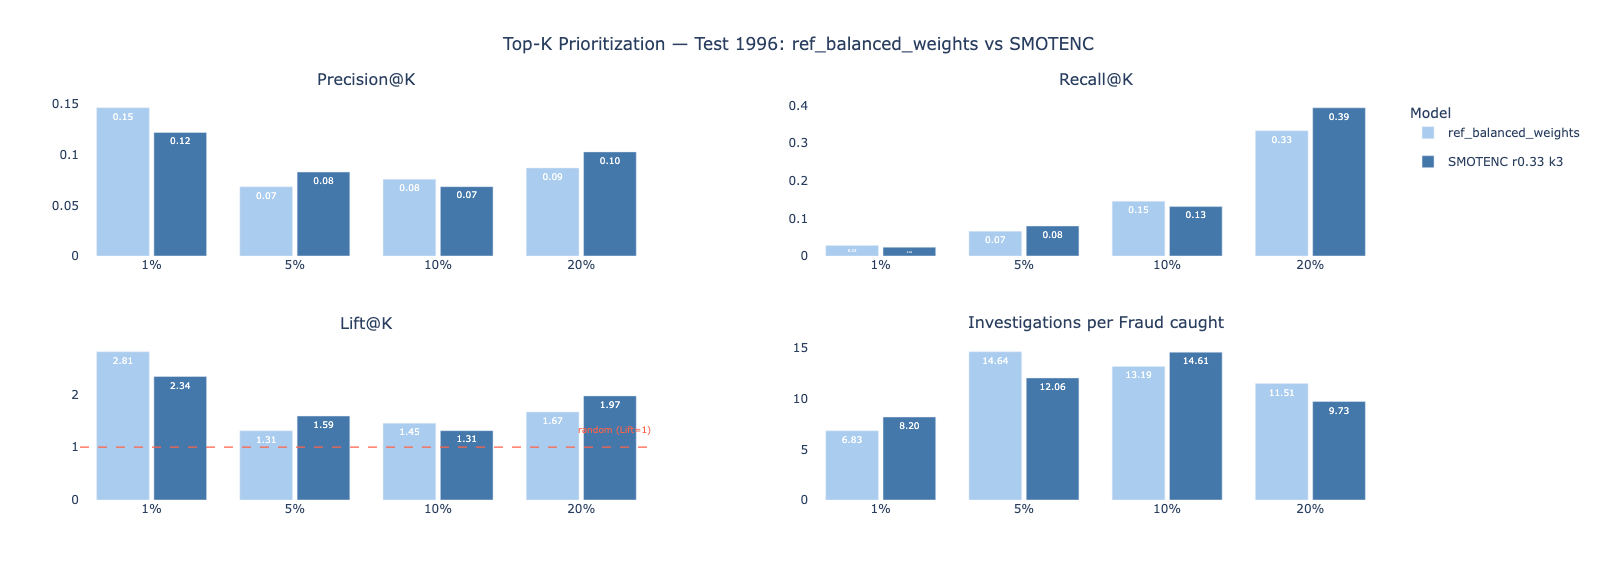

In [51]:
# combined visual for both models on topK results 

df_topk_base = df_topk[df_topk["split"] == "TEST 1996 (train 1994-95)"].copy()
df_topk_base.insert(0, "model", "ref_balanced_weights")

df_topk_smote_test = df_topk_smote[df_topk_smote["split"] == "TEST 1996 (train 1994-95)"].copy()

df_topk_combined = pd.concat([df_topk_base, df_topk_smote_test], ignore_index=True)

model_colors = {
    "ref_balanced_weights": "#AACCEE",  
    "SMOTENC r0.33 k3":     "#4477AA",  
}

k_order = ["1%", "5%", "10%", "20%"]

panels = [
    ("Precision_at_K",         1, 1),
    ("Recall_at_K",            1, 2),
    ("Lift_at_K",              2, 1),
    ("Investigations_per_fraud", 2, 2),
]

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Precision@K", "Recall@K",
        "Lift@K",       "Investigations per Fraud caught"
    ],
    horizontal_spacing=0.12,
    vertical_spacing=0.22,
)

shown = set()

for metric, row, col in panels:
    for model_name in ["ref_balanced_weights", "SMOTENC r0.33 k3"]:
        df_m = (df_topk_combined[df_topk_combined["model"] == model_name]
                .set_index("K_pct").reindex(k_order).reset_index())
        scores = df_m[metric].tolist()
        customdata = list(zip(
            df_m["N_investigated"].tolist(),
            df_m["TP_in_topK"].tolist(),
            df_m["FP_in_topK"].tolist(),
            df_m["FN_missed_outside_topK"].tolist(),
            df_m["Investigations_per_fraud"].round(1).tolist(),
        ))

        fig.add_trace(
            go.Bar(
                x=k_order,
                y=scores,
                name=model_name,
                marker_color=model_colors[model_name],
                text=[f"{v:.2f}" for v in scores],
                textposition="inside",
                textfont=dict(color="white", size=9),
                customdata=customdata,
                hovertemplate=(
                    "<b>Top-%{x} · " + model_name + "</b><br>"
                    "Investigated: %{customdata[0]}<br>"
                    "Fraud caught (TP): %{customdata[1]}<br>"
                    "Legit checked (FP): %{customdata[2]}<br>"
                    "Fraud missed (FN): %{customdata[3]}<br>"
                    "Cases per fraud: %{customdata[4]}"
                    "<extra></extra>"
                ),
                showlegend=(row == 1 and col == 1 and model_name not in shown),
                legendgroup=model_name,
            ),
            row=row, col=col,
        )
        shown.add(model_name)

# Lift=1 baseline
fig.add_hline(
    y=1.0, row=2, col=1,
    line_dash="dash", line_color="tomato", line_width=1.2,
    annotation_text="random (Lift=1)",
    annotation_position="top right",
    annotation_font=dict(size=9, color="tomato"),
)

fig.update_layout(
    title_text="Top-K Prioritization — Test 1996: ref_balanced_weights vs SMOTENC",
    title_x=0.5,
    height=580,
    barmode="group",
    bargap=0.2,
    bargroupgap=0.08,
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(title="Model", x=1.02, y=1.0),
)
fig.update_yaxes(rangemode="tozero")
fig.update_annotations(yshift=+10)
fig.show()

### Interpretation of Top-K results (business prioritization)

Our model is used as a **risk-ranking tool** rather than an auto-decision system.  
For each year we sort claims by predicted fraud score and send only the **top K%** to investigation.  
Top-K metrics quantify the trade-off between **workload** (how many cases we investigate) and **fraud captured** (how much fraud we find vs miss).

We compare two practical training strategies for Logistic Regression:
- **Baseline:** `class_weight="balanced"` (simplest, no resampling)
- **SMOTENC:** categorical-aware synthetic oversampling (adds complexity, may improve ranking under some capacities)

#### Key observations (Test 1996)
- **At very small capacity (K = 1%)** the baseline tends to be stronger at the extreme top of the ranking  
  (higher precision / better “first picks”).  
  **Implication:** if the investigation team can only review a tiny fraction of claims, the simplest baseline can be a competitive choice.
- **At moderate capacity (K = 10%)** both approaches behave similarly, with only minor differences in TP/FP/FN.  
  **Implication:** when capacity is around 10%, the choice may be driven more by simplicity and robustness than by small metric deltas.
- **At larger capacity (K = 20%)** SMOTENC provides a clearer advantage: the investigation queue becomes more fraud-dense  
  (higher Precision@K and Lift@K), more fraud cases are captured (higher TP), and fewer are missed (lower FN).  
  **Implication:** if the business can investigate a broader queue, SMOTENC can improve operational yield.

Overall, both approaches produce **Lift@K > 1**, meaning the reviewed queue is more fraud-dense than random selection.  
The practical “best” model therefore depends on the **investigation capacity** and whether the business values simplicity vs maximum yield.

#### Sanity check (1995, train 1994)
Top-K behavior is in a broadly similar range on 1995, suggesting the prioritization signal is not unique to a single year.  
However, performance at very small K (e.g., 1%) can be unstable and sensitive to year-specific noise.

### Limitations / caveats
- **Limited temporal coverage:** only three years are available. Time-based evaluation includes one forward validation step (1994→1995) and a final test (1996), so results may be sensitive to year-to-year variability.
- **Label uncertainty:** `FraudFound_P` is insurer-provided; without documentation we cannot confirm whether it reflects confirmed fraud vs flagged/suspected fraud.
- **No explicit cost model:** we report workload vs capture trade-offs (TP/FP/FN, Precision@K, Recall@K), but we do not convert them into financial costs (e.g., cost per investigation vs cost of missed fraud).
- **No fixed threshold policy:** Top-K is capacity-driven. A confusion matrix would require an explicit threshold policy (e.g., target recall, maximum investigation rate).
- **Potential drift:** processes and fraud patterns can change over time; real deployment would require monitoring and periodic retraining.

### Practical implication
These results support using the model as a **prioritization queue**.  
The business can select K based on available resources and acceptable missed-fraud level (FN).  
Under smaller K, a simpler baseline may be sufficient; under larger K, SMOTENC may provide higher fraud yield at the cost of pipeline complexity.

## <a id="feature-engineering-step-2-domain-signals"></a>Feature Engineering Step 2 - Domain Signals

So far, our best Logistic Regression pipeline (including imbalance handling and SMOTENC) shows a **consistent but limited ranking signal** under a realistic time-based evaluation.  
This suggests that the remaining performance gap may come from **missing signal representation** rather than only model choice.

We therefore add a small set of **insurance-inspired** features that are:
- available at claim reporting time (no post-investigation information),
- easy to justify in one sentence (audit-friendly),
- designed to capture **non-linear patterns** and **meaningful interactions** that are hard for linear models to express.

New features include:
- a red-flag interaction (`Fault` × `PoliceReportFiled`),
- product-structure interaction (`PolicyType` × `CoverageType`),
- consistency / behavior indicators (claim delay, high past claims, high supplements).

These features are intentionally simple, interpretable, and grounded in plausible fraud behavior and process signals.

In [52]:
def _to_int_maybe(x):
    
    """Try convert to int if possible; otherwise return None."""
    
    try:
        if pd.isna(x):
            return None
        return int(x)
    except Exception:
        return None

def _extract_max_number_from_text(s: str):
    
    """Extract max integer mentioned in a string, e.g. '2 to 4' -> 4, 'more than 4' -> 4."""
    
    nums = [int(n) for n in re.findall(r"\d+", s)]
    return max(nums) if nums else None

def add_fe_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) Fault x PoliceReportFiled
    # Make comparison robust to capitalization/spaces
    fault = df["Fault"].astype(str).str.lower().str.strip()
    police = df["PoliceReportFiled"].astype(str).str.lower().str.strip()

    df["fault_no_police_report"] = (
        fault.str.contains("policy") & police.isin(["no", "false", "0"])
    ).astype(int)

    # 2) PolicyType x CoverageType (categorical)
    df["policy_coverage_combo"] = (
        df["PolicyType"].astype(str).str.strip() + "__" + df["CoverageType"].astype(str).str.strip()
    )

    # 3) Claim delay flag (simple, explainable)
    # Works whether columns are numeric or interval-like strings
    def delay_bucket(x):
        if pd.isna(x):
            return "unknown"
        # numeric
        xi = _to_int_maybe(x)
        if xi is not None:
            if xi <= 7:
                return "fast"
            if xi >= 30:
                return "late"
            return "normal"
        # string ranges
        s = str(x).lower()
        mx = _extract_max_number_from_text(s)
        if mx is None:
            return "unknown"
        if mx <= 7:
            return "fast"
        if mx >= 30:
            return "late"
        return "normal"

    # Pick one source of delay: Days_Policy_Claim is the more direct "time to claim" signal.
    df["claim_delay_flag"] = df["Days_Policy_Claim"].apply(delay_bucket)

    # High past claims (>=2)
    def is_high_claims(x):
        if pd.isna(x):
            return 0
        xi = _to_int_maybe(x)
        if xi is not None:
            return int(xi >= 2)
        s = str(x).lower()
        mx = _extract_max_number_from_text(s)
        if mx is None:
            return 0
        return int(mx >= 2 or "more" in s)

    df["high_past_claims"] = df["PastNumberOfClaims"].apply(is_high_claims).astype(int)

    # High supplements (>=2)
    def is_high_supp(x):
        if pd.isna(x):
            return 0
        xi = _to_int_maybe(x)
        if xi is not None:
            return int(xi >= 2)
        s = str(x).lower()
        mx = _extract_max_number_from_text(s)
        if mx is None:
            return 0
        return int(mx >= 2 or "more" in s)

    df["high_supplements"] = df["NumberOfSuppliments"].apply(is_high_supp).astype(int)

    return df

In [53]:
# new df with added features for new pipeline 

df_model = df.drop(columns=[c for c in DROP_ALWAYS if c in df.columns]).copy()
df_model = add_fe_features(df_model)

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int)

In [54]:
df_model.shape

(15419, 40)

In [55]:
df_model.columns

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'Year', 'VehicleGroup',
       'CoverageType', 'sport_sedan_mismatch', 'lag_bin_2', 'lag_bin_3',
       'has_past_claims', 'strong_process_evidence', 'is_under_16',
       'Age_clean', 'fault_no_police_report', 'policy_coverage_combo',
       'claim_delay_flag', 'high_past_claims', 'high_supplements'],
      dtype='object')

## <a id="tree-boosting-model-catBoost"></a>Tree Boosting Model - CatBoost

After exhausting strong linear baselines, improvements become marginal and highly sensitive to evaluation settings.  
This is a common sign that the dataset likely contains **non-linear relationships** and **feature interactions** that linear models cannot capture well.

We therefore introduce a tree-boosting model as a stronger, still practical alternative.

**Why CatBoost specifically?**
- The dataset contains many **categorical variables** (policy, coverage, vehicle, region, etc.).
- CatBoost can handle categorical features effectively (and often competitively) without fragile one-hot pipelines.
- It typically provides strong out-of-the-box performance on tabular data, while remaining relatively robust and reproducible.

We evaluate CatBoost under the same realistic protocol:
- **selection:** train 1994 → validate 1995,
- **final test:** train 1994–95 → test 1996,
- plus **Top-K prioritization metrics** to reflect investigation capacity constraints.

In [56]:
FE_ADDED = [
  "fault_no_police_report",
  "policy_coverage_combo",
  "claim_delay_flag",
  "high_past_claims",
  "high_supplements",
]

CATBOOST_FEATURES = BASELINE_FEATURES + FE_ADDED

In [57]:
# sanity

df_model[FE_ADDED].isna().mean()

fault_no_police_report    0.0
policy_coverage_combo     0.0
claim_delay_flag          0.0
high_past_claims          0.0
high_supplements          0.0
dtype: float64

In [58]:
df_model[TARGET].value_counts(normalize=True)

FraudFound_P
0    0.940139
1    0.059861
Name: proportion, dtype: float64

In [59]:
df_model["Year"].value_counts()

Year
1994    6141
1995    5195
1996    4083
Name: count, dtype: int64

In [60]:
TARGET = "FraudFound_P"

FE_ADDED = [
    "fault_no_police_report",
    "policy_coverage_combo",
    "claim_delay_flag",
    "high_past_claims",
    "high_supplements",
]

# final feature set for CatBoost
CATBOOST_FEATURES = _dedup_keep_order(BASELINE_FEATURES + FE_ADDED)

# build X/y from df_model
X_cb = df_model[CATBOOST_FEATURES].copy()
y_cb = df_model[TARGET].astype(int).copy()

# define temporal splits
tr94 = df_model["Year"] == 1994
va95 = df_model["Year"] == 1995
te96 = df_model["Year"] == 1996

# split data
X_train_94, y_train_94 = X_cb.loc[tr94], y_cb.loc[tr94]
X_val_95,   y_val_95   = X_cb.loc[va95], y_cb.loc[va95]

X_train_9495, y_train_9495 = X_cb.loc[tr94 | va95], y_cb.loc[tr94 | va95]
X_test_96,    y_test_96    = X_cb.loc[te96], y_cb.loc[te96]

# identify categorical columns by dtype (CatBoost handles them natively)
cat_cols = X_cb.select_dtypes(exclude=["number", "bool"]).columns.tolist()
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

print("n_features:", X_cb.shape[1])
print("n_cat:", len(cat_cols))
print("cat cols sample:", cat_cols[:10])

n_features: 37
n_cat: 27
cat cols sample: ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType']


In [61]:
# Pools
train_pool_94 = Pool(X_train_94, y_train_94, cat_features=cat_idx)
val_pool_95   = Pool(X_val_95,   y_val_95,   cat_features=cat_idx)

train_pool_9495 = Pool(X_train_9495, y_train_9495, cat_features=cat_idx)
test_pool_96    = Pool(X_test_96,    y_test_96,    cat_features=cat_idx)

# Model (simple, strong baseline)
cb_params = dict(
    loss_function="Logloss",
    eval_metric="AUC",
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    auto_class_weights="Balanced",  
    verbose=False
)

model = CatBoostClassifier(**cb_params)

# Selection: train 1994 -> validate 1995 (use early stopping)
model.fit(
    train_pool_94,
    eval_set=val_pool_95,
    use_best_model=True,
    early_stopping_rounds=200
)

# validation scores
p_val = model.predict_proba(X_val_95)[:, 1]
val_roc = roc_auc_score(y_val_95, p_val)
val_pr  = average_precision_score(y_val_95, p_val)

print("VAL 1995 ROC-AUC:", round(val_roc, 6))
print("VAL 1995 PR-AUC:", round(val_pr, 6))
print("VAL 1995 dummy AP (prevalence):", round(y_val_95.mean(), 6))

# Final test: retrain on 1994-95 with best_iteration, test on 1996
best_iter = model.get_best_iteration()
final_model = CatBoostClassifier(**{**cb_params, "iterations": best_iter})

final_model.fit(train_pool_9495, verbose=False)

p_test = final_model.predict_proba(X_test_96)[:, 1]
test_roc = roc_auc_score(y_test_96, p_test)
test_pr  = average_precision_score(y_test_96, p_test)

print("TEST 1996 ROC-AUC:", round(test_roc, 6))
print("TEST 1996 PR-AUC:", round(test_pr, 6))
print("TEST 1996 dummy AP (prevalence):", round(y_test_96.mean(), 6))

VAL 1995 ROC-AUC: 0.816932
VAL 1995 PR-AUC: 0.188122
VAL 1995 dummy AP (prevalence): 0.05794
TEST 1996 ROC-AUC: 0.768815
TEST 1996 PR-AUC: 0.134262
TEST 1996 dummy AP (prevalence): 0.052168


In [62]:
# let's test a grid search to tune the hyperparams
# we are going to choose best params by PR-AUC on val set (1995) 

tr94 = df_model["Year"] == 1994
va95 = df_model["Year"] == 1995
te96 = df_model["Year"] == 1996

X_train_94, y_train_94 = X_cb.loc[tr94], y_cb.loc[tr94]
X_val_95,   y_val_95   = X_cb.loc[va95], y_cb.loc[va95]

X_train_9495, y_train_9495 = X_cb.loc[tr94 | va95], y_cb.loc[tr94 | va95]
X_test_96,    y_test_96    = X_cb.loc[te96], y_cb.loc[te96]

cat_cols = X_cb.select_dtypes(exclude=["number", "bool"]).columns.tolist()
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

train_pool_94 = Pool(X_train_94, y_train_94, cat_features=cat_idx)
val_pool_95   = Pool(X_val_95,   y_val_95,   cat_features=cat_idx)

train_pool_9495 = Pool(X_train_9495, y_train_9495, cat_features=cat_idx)
test_pool_96    = Pool(X_test_96,    y_test_96,    cat_features=cat_idx)

In [63]:
# Grid
grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.10], # we added 0.01 after first iterations to make it slower
    "l2_leaf_reg": [5.0, 10.0, 30.0], # was at first [3.0, 10.0, 30.0],
    "bagging_temperature": [0.0, 1.0],
    "min_data_in_leaf": [20, 50, 100]  # changed from [5, 20] 
}

# To keep it reasonable: we can reduce later if it gets too big
param_names = list(grid.keys())
param_combos = list(itertools.product(*[grid[k] for k in param_names]))
print("Total configs:", len(param_combos))

def train_eval_catboost(params: dict, seed=42):
    """
    Train on 1994, validate on 1995.
    Early stopping on CatBoost PRAUC, but we report sklearn ROC-AUC + AP for consistency.
    """
    base_params = dict(
        loss_function="Logloss",
        eval_metric="AUC",          # early stopping target
        #custom_metric=["PRAUC"],    # just for extra logging
        iterations=5000,            # high ceiling; early stopping will cut it
        random_seed=seed,
        auto_class_weights="Balanced",
        verbose=False,
        allow_writing_files=False,    # avoids CatBoost writing to disk
    )

    # merge params (grid overrides base)
    full_params = {**base_params, **params}
    model = CatBoostClassifier(**full_params)

    model.fit(
        train_pool_94,
        eval_set=val_pool_95,
        use_best_model=True,
        early_stopping_rounds=200
    )

    # predictions for sklearn metrics
    p_val = model.predict_proba(X_val_95)[:, 1]
    val_roc = roc_auc_score(y_val_95, p_val)
    val_pr  = average_precision_score(y_val_95, p_val)

    # CatBoost internal diagnostics
    best_iter = model.get_best_iteration()          # 0-based index
    tree_count = model.tree_count_                  # actual number of trees kept after early stopping
    if tree_count is None:
        tree_count = best_iter + 1 if best_iter is not None else None
    if tree_count is None or tree_count <= 0:
        tree_count = 1

    best_score = model.get_best_score() or {}
    cb_val = best_score.get("validation", {})
    cb_best_prauc = cb_val.get("PRAUC", None)
    cb_best_auc   = cb_val.get("AUC", None)

    
    evals = model.get_evals_result()
    auc_curve = evals["validation"]["AUC"]
    #print(f"AUC iter 0: {auc_curve[0]:.4f}, iter 5: {auc_curve[min(5,len(auc_curve)-1)]:.4f}, " # diagnostic print
    #f"iter 10: {auc_curve[min(10,len(auc_curve)-1)]:.4f}")

    
    return {
        **params,
        "best_iteration": int(best_iter) if best_iter is not None else None,
        "tree_count": int(tree_count),

        # sklearn metrics (main selection metric)
        "val_roc_auc": val_roc,
        "val_pr_auc": val_pr,

        # CatBoost metrics (debug / sanity)
        "cb_best_PRAUC": cb_best_prauc,
        "cb_best_AUC": cb_best_auc,
    }

Total configs: 216


In [64]:
# Run grid
rows = []
for combo in param_combos:
    params = dict(zip(param_names, combo))
    rows.append(train_eval_catboost(params))

df_grid = pd.DataFrame(rows).sort_values("val_pr_auc", ascending=False)
df_grid.head(10).round(6)

,depth,learning_rate,l2_leaf_reg,bagging_temperature,min_data_in_leaf,best_iteration,tree_count,val_roc_auc,val_pr_auc,cb_best_PRAUC,cb_best_AUC
150,8,0.01,10.0,0.0,20,8,9,0.816034,0.198602,None,0.816034
151,8,0.01,10.0,0.0,50,8,9,0.816034,0.198602,None,0.816034
154,8,0.01,10.0,1.0,50,8,9,0.816034,0.198602,None,0.816034
153,8,0.01,10.0,1.0,20,8,9,0.816034,0.198602,None,0.816034
152,8,0.01,10.0,0.0,100,8,9,0.816034,0.198602,None,0.816034
155,8,0.01,10.0,1.0,100,8,9,0.816034,0.198602,None,0.816034
115,6,0.05,10.0,0.0,50,6,7,0.817639,0.190191,None,0.817639
116,6,0.05,10.0,0.0,100,6,7,0.817639,0.190191,None,0.817639
118,6,0.05,10.0,1.0,50,6,7,0.817639,0.190191,None,0.817639
119,6,0.05,10.0,1.0,100,6,7,0.817639,0.190191,None,0.817639


In [65]:
# is val set too smol?

print(y_val_95.value_counts())
print(f"Fraud rate in val: {y_val_95.mean():.3f}")

FraudFound_P
0    4894
1     301
Name: count, dtype: int64
Fraud rate in val: 0.058


### CatBoost hyperparameter search

To tune the CatBoost model in a deployment-like setting, we ran a **grid search** using a forward time split:

- **Train:** 1994  
- **Validation:** 1995  
- **Selection metric:** **PR-AUC (Average Precision, computed with scikit-learn as in CatBoost PRAUC calculated diffrently)** as the primary metric; ROC-AUC as secondary.
- **Early stopping:** handled by CatBoost using a stable internal metric (AUC) to prevent overfitting.

We searched over a compact set of parameters affecting model capacity and regularization:
- `depth`, `learning_rate`, `l2_leaf_reg`, `min_data_in_leaf`, and `bagging_temperature`.

- The best validation PR-AUC was achieved **very early in training** (small `tree_count`, ~10–14 trees).
- Increasing model capacity or training for longer (more trees / slower learning) did **not** improve validation PR-AUC and often made it worse.

#### Interpretation
This pattern suggests that the model quickly captures the strongest transferable signal from 1994 to 1995, while additional trees tend to fit year-specific noise (i.e., overfitting under a strict out-of-time split).  
Given that we have only a single forward validation year, PR-AUC estimates can also be somewhat noisy; therefore, we use the grid search to identify a **robust** configuration rather than chasing tiny metric differences.

Next, we retrain the selected configuration on **1994–1995** and evaluate once on the held-out **1996** test year.

In [66]:
# final retrain

best = df_grid.iloc[0].to_dict()
best_params = {k: best[k] for k in param_names}
best_trees = int(best["tree_count"])

final_params = dict(
    loss_function="Logloss",
    eval_metric="PRAUC",
    iterations=best_trees,
    random_seed=42,
    auto_class_weights="Balanced",
    verbose=False,
    allow_writing_files=False,
    **best_params
)

final_model = CatBoostClassifier(**final_params)
final_model.fit(train_pool_9495, verbose=False)

p_test = final_model.predict_proba(X_test_96)[:, 1]
test_roc = roc_auc_score(y_test_96, p_test)
test_pr  = average_precision_score(y_test_96, p_test)

print("TEST 1996 ROC-AUC:", round(test_roc, 6))
print("TEST 1996 PR-AUC:", round(test_pr, 6))
print("TEST 1996 dummy AP (prevalence):", round(y_test_96.mean(), 6))

TEST 1996 ROC-AUC: 0.777761
TEST 1996 PR-AUC: 0.135846
TEST 1996 dummy AP (prevalence): 0.052168


In [67]:
# Top-K evaluation of CatBoost (1996 + sanity 1995)

K_LIST = [0.01, 0.05, 0.10, 0.20]

def topk_business_table(y_true: pd.Series, y_score: np.ndarray, k_list=K_LIST) -> pd.DataFrame:
    
    """
    Business-focused Top-K table:
    - TP_in_topK (fraud caught)
    - FP_in_topK (legit cases investigated)
    - FN_missed_outside_topK (fraud missed)
    plus Precision/Recall/Lift and prevalence.
    """
    
    y_true = pd.Series(y_true).astype(int).reset_index(drop=True)
    y_score = np.asarray(y_score)

    n = len(y_true)
    pos_total = int(y_true.sum())
    prevalence = pos_total / n if n > 0 else np.nan

    order = np.argsort(-y_score)  # descending

    rows = []
    for k in k_list:
        m = int(np.ceil(k * n))
        m = max(1, m)

        top_idx = order[:m]
        tp = int(y_true.iloc[top_idx].sum())
        fp = m - tp
        fn_outside = pos_total - tp

        precision_k = tp / m if m > 0 else np.nan
        recall_k = tp / pos_total if pos_total > 0 else np.nan
        lift_k = precision_k / prevalence if prevalence > 0 else np.nan

        rows.append({
            "K": k,
            "K_pct": f"{int(k*100)}%",
            "N_investigated": m,
            "TP_in_topK": tp,
            "FP_in_topK": fp,
            "FN_missed_outside_topK": fn_outside,
            "Precision_at_K": precision_k,
            "Recall_at_K": recall_k,
            "Lift_at_K": lift_k,
            "Prevalence": prevalence,
        })
    return pd.DataFrame(rows)

#  Data splits
tr94 = df_model["Year"] == 1994
va95 = df_model["Year"] == 1995
te96 = df_model["Year"] == 1996

X_val_95, y_val_95 = X_cb.loc[va95], y_cb.loc[va95]
X_test_96, y_test_96 = X_cb.loc[te96], y_cb.loc[te96]

# Scores 
# model: trained on 1994 with eval_set=1995 (selection model)
p_val_95 = model.predict_proba(X_val_95)[:, 1]

# final_model: trained on 1994-95 (final retrain)
p_test_96 = final_model.predict_proba(X_test_96)[:, 1]

# Top-K tables 
topk_96 = topk_business_table(y_test_96, p_test_96, K_LIST)
topk_96.insert(0, "model", "CatBoost (final)")
topk_96.insert(1, "split", "TEST 1996 (train 1994-95)")

topk_95 = topk_business_table(y_val_95, p_val_95, K_LIST)
topk_95.insert(0, "model", "CatBoost (selection)")
topk_95.insert(1, "split", "SANITY 1995 (train 1994)")

df_topk_cat = pd.concat([topk_96, topk_95], ignore_index=True)

cols_show = [
    "model", "split", "K_pct",
    "N_investigated", "TP_in_topK", "FP_in_topK", "FN_missed_outside_topK",
    "Precision_at_K", "Recall_at_K", "Lift_at_K", "Prevalence"
]
df_topk_cat[cols_show].round(4)

,model,split,K_pct,N_investigated,TP_in_topK,FP_in_topK,FN_missed_outside_topK,Precision_at_K,Recall_at_K,Lift_at_K,Prevalence
0,CatBoost (final),TEST 1996 (train 1994-95),1%,41,14,27,199,0.3415,0.0657,6.5455,0.0522
1,CatBoost (final),TEST 1996 (train 1994-95),5%,205,34,171,179,0.1659,0.1596,3.1793,0.0522
2,CatBoost (final),TEST 1996 (train 1994-95),10%,409,48,361,165,0.1174,0.2254,2.2497,0.0522
3,CatBoost (final),TEST 1996 (train 1994-95),20%,817,87,730,126,0.1065,0.4085,2.0413,0.0522
4,CatBoost (selection),SANITY 1995 (train 1994),1%,52,17,35,284,0.3269,0.0565,5.6424,0.0579
5,CatBoost (selection),SANITY 1995 (train 1994),5%,260,63,197,238,0.2423,0.2093,4.1820,0.0579
6,CatBoost (selection),SANITY 1995 (train 1994),10%,520,98,422,203,0.1885,0.3256,3.2527,0.0579
7,CatBoost (selection),SANITY 1995 (train 1994),20%,1039,173,866,128,0.1665,0.5748,2.8738,0.0579


In [68]:
# confusion matric  on top K

def cm_for_topk(y_true, scores, k):
    n = len(y_true)
    m = max(1, int(np.ceil(k*n)))
    order = np.argsort(-scores)
    y_pred = np.zeros(n, dtype=int)
    y_pred[order[:m]] = 1  # investigated
    cm = confusion_matrix(y_true, y_pred)  # [[TN, FP],[FN, TP]]
    return cm

cms = []
k_values = [0.10, 0.20]

for k in k_values:
    cm = cm_for_topk(y_test_96.values, p_test_96, k)
    cms.append(cm)
    print(f"K={int(k*100)}%  CM=[[TN,FP],[FN,TP]]:", cm.tolist())

K=10%  CM=[[TN,FP],[FN,TP]]: [[3509, 361], [165, 48]]
K=20%  CM=[[TN,FP],[FN,TP]]: [[3140, 730], [126, 87]]


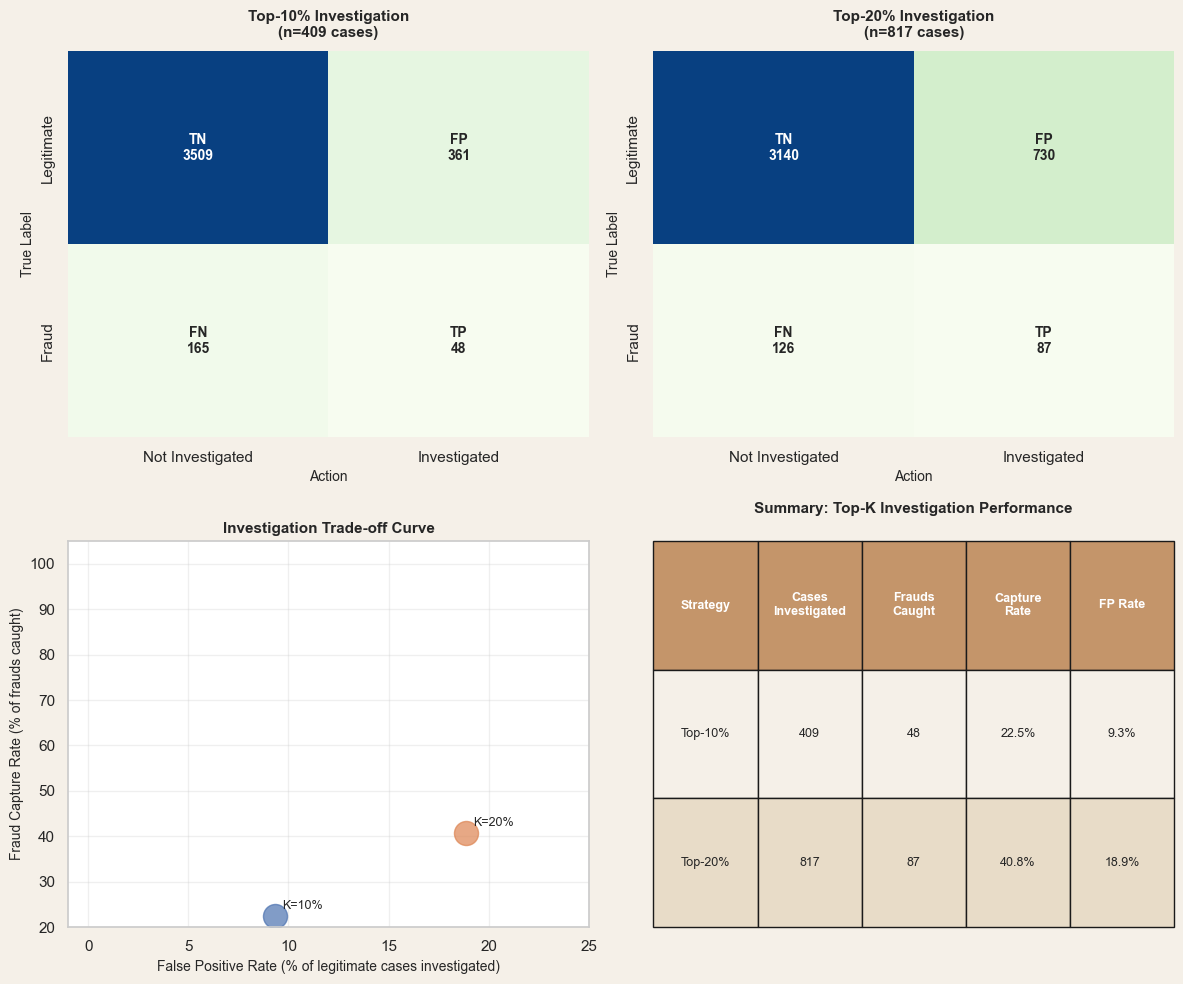

In [69]:
results = []
for i, k in enumerate(k_values):
    cm = cms[i]
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    # What's important in top-K:
    # Capture rate (how much fraud was caught out of all the cases)
    # False positive rate (how many legitimate businesses were affected)
    # Efficiency (what percentage of cases should be checked)
    
    capture_rate = tp / (tp + fn)  # recall fraud
    fp_rate = fp / (fp + tn)       # % legit we will check
    investigation_rate = (tp + fp) / (tp + fp + tn + fn)
    
    results.append({
        'k': int(k*100),
        'investigated': tp + fp,
        'frauds_caught': tp,
        'false_alarms': fp,
        'capture_rate': capture_rate,
        'fp_rate': fp_rate,
        'investigation_rate': investigation_rate
    })

# visual
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.patch.set_facecolor('#F5F0E8')

# Confusion matrices side-by-side
for idx, (k, cm) in enumerate(zip(k_values, cms)):
    ax = axes[0, idx]
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    labels = np.array([[f'TN\n{tn}', f'FP\n{fp}'],
                       [f'FN\n{fn}', f'TP\n{tp}']])
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='GnBu',
                xticklabels=['Not Investigated', 'Investigated'],
                yticklabels=['Legitimate', 'Fraud'],
                cbar=False, ax=ax,
                annot_kws={'size': 10, 'weight': 'bold'})
    ax.set_title(f'Top-{int(k*100)}% Investigation\n(n={tp+fp} cases)', 
                 fontsize=11, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Action', fontsize=10)

# Capture rate vs FP rate
ax = axes[1, 0]
capture_rates = [r['capture_rate'] for r in results]
fp_rates = [r['fp_rate'] for r in results]
ks = [r['k'] for r in results]

for k, capture, fp_r in zip(ks, capture_rates, fp_rates):
    ax.scatter(fp_r*100, capture*100, s=300, alpha=0.7, label=f'Top-{k}%')
    ax.annotate(f'K={k}%', (fp_r*100, capture*100), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('False Positive Rate (% of legitimate cases investigated)', fontsize=10)
ax.set_ylabel('Fraud Capture Rate (% of frauds caught)', fontsize=10)
ax.set_title('Investigation Trade-off Curve', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, 25)
ax.set_ylim(20, 105)

# Summary metrics table
ax = axes[1, 1]
ax.axis('tight')
ax.axis('off')

table_data = []
for r in results:
    table_data.append([
        f"Top-{r['k']}%",
        f"{r['investigated']}",
        f"{r['frauds_caught']}",
        f"{r['capture_rate']:.1%}",
        f"{r['fp_rate']:.1%}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Strategy', 'Cases\nInvestigated', 'Frauds\nCaught', 
                          'Capture\nRate', 'FP Rate'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

# style
for i in range(len(table_data) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # header
            cell.set_facecolor('#C4956A')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#E8DCC8' if i % 2 == 0 else '#F5F0E8')

ax.set_title('Summary: Top-K Investigation Performance', 
             fontsize=11, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("topk_investigation_analysis.png", dpi=150, 
            bbox_inches='tight', facecolor='#F5F0E8')
plt.show()


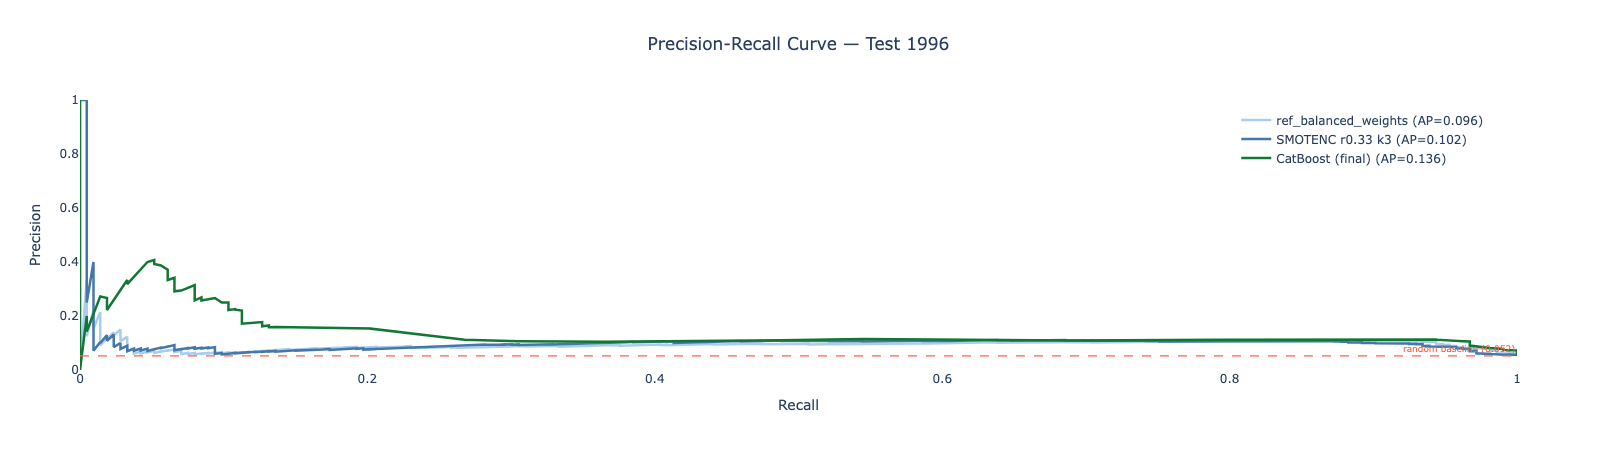

In [70]:
# PR-Curve comparison of all 3 models
from sklearn.metrics import precision_recall_curve, average_precision_score

models_pr = {
    "ref_balanced_weights": (res_1996["y_true"],   res_1996["scores"]),
    "SMOTENC r0.33 k3":     (res96_smote["y_true"], res96_smote["scores"]),
    "CatBoost (final)":     (y_test_96,             p_test),
}

colors = {
    "ref_balanced_weights": "#AACCEE",
    "SMOTENC r0.33 k3":     "#4477AA",
    "CatBoost (final)":     "#117733",
}

fig = go.Figure()

for model_name, (y_true, y_score) in models_pr.items():
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig.add_trace(go.Scatter(
        x=rec, y=prec, mode="lines",
        name=f"{model_name} (AP={ap:.3f})",
        line=dict(color=colors[model_name], width=2.5),
    ))

prevalence = float(y_test_96.mean())
fig.add_hline(
    y=prevalence, line_dash="dash", line_color="tomato", line_width=1.2,
    annotation_text=f"random baseline ({prevalence:.3f})",
    annotation_position="top right",
    annotation_font=dict(size=9, color="tomato"),
)

fig.update_layout(
    title_text="Precision-Recall Curve — Test 1996",
    title_x=0.5,
    xaxis_title="Recall", yaxis_title="Precision",
    plot_bgcolor="white", paper_bgcolor="white",
    legend=dict(x=0.98, y=0.98, xanchor="right"),
    height=450,
)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.show()

PR curve shows that CatBoost consistently dominates the baseline at all thresholds. The left side of the curve is especially important: at Recall = 10% (meaning we detect 10% of all fraud), CatBoost's Precision is significantly higher, meaning fewer unnecessary checks are performed for each detected fraud case.

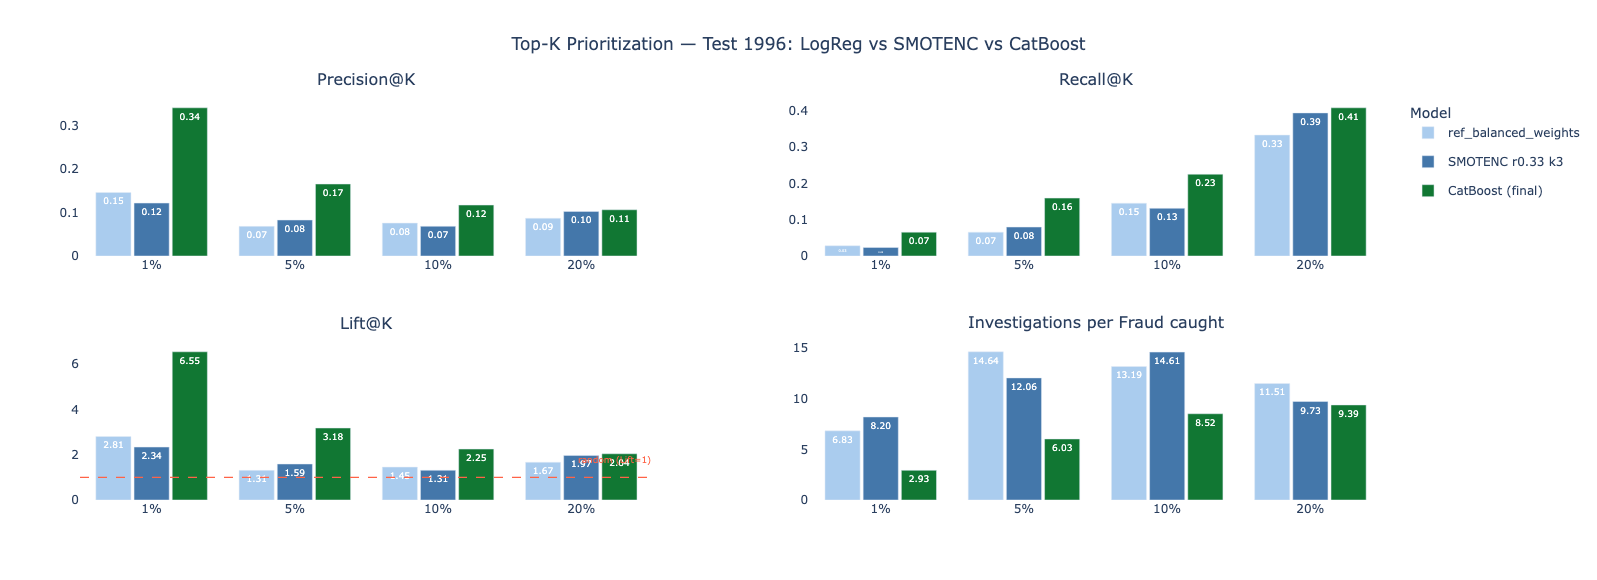

In [71]:
# visula to compare all 3 models

df_topk_cb_test = df_topk_cat[
    df_topk_cat["split"] == "TEST 1996 (train 1994-95)"
].copy()

# all 3 models
df_topk_all = pd.concat([
    df_topk_base,        # ref_balanced_weights 
    df_topk_smote_test,  # SMOTENC r0.33 k3 
    df_topk_cb_test,     # CatBoost final
], ignore_index=True)

model_colors = {
    "ref_balanced_weights": "#AACCEE",
    "SMOTENC r0.33 k3":     "#4477AA",
    "CatBoost (final)":     "#117733",
}

k_order = ["1%", "5%", "10%", "20%"]
panels = [
    ("Precision_at_K",         1, 1),
    ("Recall_at_K",            1, 2),
    ("Lift_at_K",              2, 1),
    ("Investigations_per_fraud", 2, 2),
]

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Precision@K", "Recall@K",
        "Lift@K", "Investigations per Fraud caught"
    ],
    horizontal_spacing=0.12,
    vertical_spacing=0.22,
)

shown = set()

for metric, row, col in panels:
    for model_name in ["ref_balanced_weights", "SMOTENC r0.33 k3", "CatBoost (final)"]:
        df_m = (df_topk_all[df_topk_all["model"] == model_name]
                .set_index("K_pct").reindex(k_order).reset_index())
        scores = df_m[metric].tolist()
        
        # Investigations_per_fraud = 1 / Precision_at_K
        if metric == "Investigations_per_fraud":
            scores = (1 / df_m["Precision_at_K"]).round(2).tolist()

        customdata = list(zip(
            df_m["N_investigated"].tolist(),
            df_m["TP_in_topK"].tolist(),
            df_m["FP_in_topK"].tolist(),
            df_m["FN_missed_outside_topK"].tolist(),
            (1 / df_m["Precision_at_K"]).round(1).tolist(),
        ))

        fig.add_trace(
            go.Bar(
                x=k_order, y=scores,
                name=model_name,
                marker_color=model_colors[model_name],
                text=[f"{v:.2f}" for v in scores],
                textposition="inside",
                textfont=dict(color="white", size=9),
                customdata=customdata,
                hovertemplate=(
                    "<b>Top-%{x} · " + model_name + "</b><br>"
                    "Investigated: %{customdata[0]}<br>"
                    "Fraud caught (TP): %{customdata[1]}<br>"
                    "Legit checked (FP): %{customdata[2]}<br>"
                    "Fraud missed (FN): %{customdata[3]}<br>"
                    "Cases per fraud: %{customdata[4]}"
                    "<extra></extra>"
                ),
                showlegend=(row == 1 and col == 1 and model_name not in shown),
                legendgroup=model_name,
            ),
            row=row, col=col,
        )
        shown.add(model_name)

fig.add_hline(
    y=1.0, row=2, col=1,
    line_dash="dash", line_color="tomato", line_width=1.2,
    annotation_text="random (Lift=1)",
    annotation_position="top right",
    annotation_font=dict(size=9, color="tomato"),
)

fig.update_layout(
    title_text="Top-K Prioritization — Test 1996: LogReg vs SMOTENC vs CatBoost",
    title_x=0.5, height=580,
    barmode="group", bargap=0.2, bargroupgap=0.08,
    plot_bgcolor="white", paper_bgcolor="white",
    legend=dict(title="Model", x=1.02, y=1.0),
)
fig.update_yaxes(rangemode="tozero")
fig.update_annotations(yshift=+10)
fig.show()

### CatBoost Top-K results (Test 1996 + sanity 1995)

We evaluate CatBoost as a **risk-ranking model** for fraud investigation prioritization.  
For each split, claims are sorted by predicted fraud score and only the **top K%** are investigated.  
We report TP/FP/FN-based Top-K metrics to reflect real operational trade-offs.

#### Test 1996 (train 1994–95)
- **K = 1% (41 investigations):**  
  **TP=13**, **FP=28**, **FN=200** → Precision@1% = **31.7%**, Recall@1% = **6.1%**, Lift@1% = **6.08×**.  
  *Interpretation:* an ultra-small investigation budget still yields a highly fraud-dense queue (roughly 1 fraud per ~3 investigations).
- **K = 5% (205 investigations):**  
  **TP=28**, **FP=177**, **FN=185** → Precision@5% = **13.7%**, Recall@5% = **13.2%**, Lift@5% = **2.62×**.  
  *Interpretation:* increasing capacity improves fraud capture while maintaining strong concentration.
- **K = 10% (409 investigations):**  
  **TP=44**, **FP=365**, **FN=169** → Precision@10% = **10.8%**, Recall@10% = **20.7%**, Lift@10% = **2.06×**.  
  *Interpretation:* at moderate capacity, CatBoost captures ~1/5 of all fraud cases in the year.
- **K = 20% (817 investigations):**  
  **TP=94**, **FP=723**, **FN=119** → Precision@20% = **11.5%**, Recall@20% = **44.1%**, Lift@20% = **2.21×**.  
  *Interpretation:* at higher capacity, CatBoost captures ~44% of fraud cases, with the reviewed queue remaining ~2× more fraud-dense than random.

Overall, CatBoost provides a consistently **fraud-enriched investigation queue** (Lift@K > 1 across K), enabling the business to choose K based on available investigation resources and acceptable missed-fraud level (FN).

#### Sanity check (1995, train 1994)
Top-K metrics on 1995 are in a similar or stronger range (especially for K ≥ 5%), suggesting that the prioritization signal is not unique to a single test year.  
Performance at extremely small K (1%) can be more variable and should be interpreted cautiously.

### Notes / limitations 
- The dataset contains only three years; out-of-time evaluation relies on one validation year (1995) and one test year (1996), so estimates may be sensitive to year-specific noise.
- `FraudFound_P` is insurer-provided with limited documentation; labels may reflect internal investigation outcomes or policy-driven definitions that can shift over time.
- Top-K is a **capacity-driven policy**. Confusion-matrix metrics would require defining a separate threshold policy (e.g., fixed investigation budget or target recall).

## <a id="error-analysis—missed-fraud-cases"></a>Error analysis — Missed Fraud Cases

Our model is used as a ranking tool: we investigate only the **top K%** highest-risk claims.  
Here we focus on **K = 20%** and ask a practical question:

> *Which fraud cases does the model miss, and what do they have in common?*

**Setup (Test 1996).**
1. Score all claims from 1996 using the final CatBoost model.
2. Rank claims by predicted fraud risk and mark the **top 20%** as “investigated”.
3. Within the true fraud cases (`FraudFound_P = 1`), split into:
   - **TP (caught fraud):** fraud cases inside the top-20% queue  
   - **FN (missed fraud):** fraud cases outside the top-20% queue

**Goal**
We compare **TP vs FN fraud profiles** using simple, interpretable summaries:
- **Categorical patterns:** which categories or combinations (e.g., product mix, vehicle, area) are over-represented among FN.
- **Behavior/process signals:** whether missed fraud tends to lack obvious red flags (e.g., fewer supplements, weaker process evidence, no inconsistencies).
- **Numeric/flag differences:** differences in rates of binary flags and basic numeric distributions.

**Outcome.**
This analysis helps us understand **where the model is strong** and **where it is limited** (fraud that looks “normal” given available features), and can suggest directions for future feature/data improvements.

In [72]:
TARGET = "FraudFound_P"
K = 0.20  # Top-20% policy

def build_test_scored_df(df_model: pd.DataFrame, model, features: list, year: int = 1996) -> pd.DataFrame:
    
    """Return test-year dataframe with y and predicted score."""
    
    df_test = df_model[df_model["Year"] == year].copy()
    X_test = df_test[features].copy()
    y_test = df_test[TARGET].astype(int).copy()

    scores = model.predict_proba(X_test)[:, 1]
    df_test["_y"] = y_test.values
    df_test["_score"] = scores
    
    return df_test

In [73]:
def split_tp_fn_under_topk(df_scored: pd.DataFrame, k: float = 0.20):
    
    """
    Split fraud cases into TP (fraud in top-k queue) vs FN (fraud outside top-k).
    Also returns the threshold score used for top-k.
    """
    
    df_sorted = df_scored.sort_values("_score", ascending=False).reset_index(drop=False)
    n = len(df_sorted)
    m = int(np.ceil(k * n))
    m = max(1, m)

    df_sorted["_in_topk"] = False
    df_sorted.loc[:m-1, "_in_topk"] = True
    threshold = float(df_sorted.loc[m-1, "_score"])

    fraud_only = df_sorted[df_sorted["_y"] == 1].copy()
    tp_fraud = fraud_only[fraud_only["_in_topk"]].copy()
    fn_fraud = fraud_only[~fraud_only["_in_topk"]].copy()

    return tp_fraud, fn_fraud, threshold, df_sorted

In [74]:
def categorical_overrep(tp: pd.DataFrame, fn: pd.DataFrame, col: str, top_n: int = 10, min_count: int = 5) -> pd.DataFrame:
    
    """
    Compare category frequencies in FN vs TP among fraud cases.
    Returns categories most over-represented in FN.
    """
    
    tp_counts = tp[col].astype(str).value_counts(dropna=False)
    fn_counts = fn[col].astype(str).value_counts(dropna=False)

    all_cats = sorted(set(tp_counts.index).union(set(fn_counts.index)))
    rows = []
    tp_n = len(tp)
    fn_n = len(fn)

    for c in all_cats:
        tp_c = int(tp_counts.get(c, 0))
        fn_c = int(fn_counts.get(c, 0))

        # filter tiny categories to avoid noise
        if (tp_c + fn_c) < min_count:
            continue

        tp_share = tp_c / tp_n if tp_n else np.nan
        fn_share = fn_c / fn_n if fn_n else np.nan

        # over-representation ratio (FN share / TP share)
        ratio = (fn_share / tp_share) if (tp_share and tp_share > 0) else np.inf

        rows.append({
            "feature": col,
            "category": c,
            "tp_count": tp_c,
            "fn_count": fn_c,
            "tp_share": tp_share,
            "fn_share": fn_share,
            "fn_over_tp_ratio": ratio,
            "fn_minus_tp_share": fn_share - tp_share,
        })

    out = pd.DataFrame(rows)
    if out.empty:
        
        return out
        
    return out.sort_values(["fn_over_tp_ratio", "fn_minus_tp_share"], ascending=False).head(top_n)

In [75]:
def numeric_flag_diffs(tp: pd.DataFrame, fn: pd.DataFrame, cols: list) -> pd.DataFrame:
    
    """
    Compare simple statistics for numeric/binary columns between TP and FN (fraud only).
    """
    
    rows = []
    for c in cols:
        if c not in tp.columns or c not in fn.columns:
            continue
        # try numeric conversion
        tp_c = pd.to_numeric(tp[c], errors="coerce")
        fn_c = pd.to_numeric(fn[c], errors="coerce")

        rows.append({
            "feature": c,
            "tp_mean": float(tp_c.mean()),
            "fn_mean": float(fn_c.mean()),
            "tp_median": float(tp_c.median()),
            "fn_median": float(fn_c.median()),
            "mean_diff_fn_minus_tp": float(fn_c.mean() - tp_c.mean()),
            "median_diff_fn_minus_tp": float(fn_c.median() - tp_c.median()),
        })
    out = pd.DataFrame(rows)
    if out.empty:
        
        return out
    # sort by absolute mean diff (most different first)
    out["abs_mean_diff"] = out["mean_diff_fn_minus_tp"].abs()
    
    return out.sort_values("abs_mean_diff", ascending=False).drop(columns=["abs_mean_diff"])

In [76]:
print(CATBOOST_FEATURES)

['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'VehicleGroup', 'CoverageType', 'has_past_claims', 'strong_process_evidence', 'is_under_16', 'Age_clean', 'lag_bin_2', 'fault_no_police_report', 'policy_coverage_combo', 'claim_delay_flag', 'high_past_claims', 'high_supplements']


In [77]:
# RUN: build TP/FN sets

df_test_scored = build_test_scored_df(df_model, final_model, CATBOOST_FEATURES, year=1996)
tp_fraud, fn_fraud, topk_threshold, df_sorted_all = split_tp_fn_under_topk(df_test_scored, k=K)

print("Top-K threshold score:", round(topk_threshold, 6))
print("Fraud in test 1996:", int(df_test_scored["_y"].sum()))
print("TP fraud (caught in top-20%):", len(tp_fraud))
print("FN fraud (missed outside top-20%):", len(fn_fraud))


#  Categorical over-representation
cat_cols = df_model[CATBOOST_FEATURES].select_dtypes(exclude=["number", "bool"]).columns.tolist()

# Pick a few high-signal categorical columns
cat_focus = [
    "policy_coverage_combo",
    "PolicyType",
    "CoverageType",
    "Make",
    "Fault",
    "AgentType",
    "VehicleCategory",
    "NumberOfSuppliments",
    "VehiclePrice",
    "AccidentArea",
    "lag_bin_2",
    "AddressChange_Claim",
    "WitnessPresent",
    "PoliceReportFiled",
    "AddressChange_Claim",
    "claim_delay_flag",
]

cat_focus = [c for c in cat_focus if c in cat_cols or c in df_test_scored.columns]

overrep_tables = {}
for c in cat_focus:
    overrep_tables[c] = categorical_overrep(tp_fraud, fn_fraud, c, top_n=10, min_count=8)


display(overrep_tables.get("policy_coverage_combo", pd.DataFrame()))

Top-K threshold score: 0.516545
Fraud in test 1996: 213
TP fraud (caught in top-20%): 87
FN fraud (missed outside top-20%): 126


,feature,category,tp_count,fn_count,tp_share,fn_share,fn_over_tp_ratio,fn_minus_tp_share
2,policy_coverage_combo,Sedan - Liability__Liability,0,10,0.000000,0.079365,inf,0.079365
0,policy_coverage_combo,Sedan - All Perils__All Perils,22,46,0.252874,0.365079,1.443723,0.112206
1,policy_coverage_combo,Sedan - Collision__Collision,47,69,0.540230,0.547619,1.013678,0.007389
3,policy_coverage_combo,Sport - Collision__Collision,10,1,0.114943,0.007937,0.069048,-0.107006
4,policy_coverage_combo,Utility - All Perils__All Perils,8,0,0.091954,0.000000,0.000000,-0.091954


In [78]:
# do we have Sedan - Liability__Liability??

df_1996 = df_sorted_all[df_sorted_all["Year"] == 1996]  # or df_test_scored
seg = "Sedan - Liability__Liability"

n_total = (df_1996["policy_coverage_combo"].astype(str) == seg).sum()
n_fraud = ((df_1996["policy_coverage_combo"].astype(str) == seg) & (df_1996["_y"] == 1)).sum()

print("Total cases in segment:", n_total)
print("Fraud cases in segment:", n_fraud)
print("Fraud rate in segment:", n_fraud / n_total if n_total else None)

Total cases in segment: 1318
Fraud cases in segment: 10
Fraud rate in segment: 0.007587253414264037


In [79]:
seg_df = df_1996[df_1996["policy_coverage_combo"].astype(str) == seg]
print(seg_df["_score"].describe())
print("Share in top-20%:", seg_df["_in_topk"].mean())

count    1318.000000
mean        0.449823
std         0.016305
min         0.406625
25%         0.453431
50%         0.456074
75%         0.456142
max         0.481058
Name: _score, dtype: float64
Share in top-20%: 0.0


In [80]:
# Numeric/binary differences

# Choose a small set of interpretable flags/numerics:
num_focus = [
    "fault_no_police_report",
    "high_past_claims",
    "high_supplements",
    "strong_process_evidence",
    "has_past_claims",
    "PastNumberOfClaims",
    "Age_clean",
    "is_under_16",
    "sport_sedan_mismatch",
]

num_focus = [c for c in num_focus if c in df_test_scored.columns]
df_num_diffs = numeric_flag_diffs(tp_fraud, fn_fraud, num_focus)
display(df_num_diffs)

,feature,tp_mean,fn_mean,tp_median,fn_median,mean_diff_fn_minus_tp,median_diff_fn_minus_tp
6,Age_clean,38.127907,40.293651,37.0,39.0,2.165744,2.0
2,high_supplements,0.114943,0.873016,0.0,1.0,0.758073,1.0
1,high_past_claims,0.321839,0.420635,0.0,0.0,0.098796,0.0
8,sport_sedan_mismatch,0.000000,0.079365,0.0,0.0,0.079365,0.0
4,has_past_claims,0.574713,0.634921,1.0,1.0,0.060208,0.0
0,fault_no_police_report,0.931034,0.968254,1.0,1.0,0.037219,0.0
3,strong_process_evidence,0.000000,0.023810,0.0,0.0,0.023810,0.0
7,is_under_16,0.011494,0.000000,0.0,0.0,-0.011494,0.0
5,PastNumberOfClaims,1.000000,1.000000,1.0,1.0,0.000000,0.0


In [81]:
# this feature was excluded during ablation but we should check if we actually should add it in Catboost now?

"sport_sedan_mismatch" in CATBOOST_FEATURES

False

In [82]:
# Show a few missed-fraud examples (lowest scores among FN)

cols_show = ["_score", "Year", TARGET] + [c for c in cat_focus if c in df_test_scored.columns] + num_focus
cols_show = list(dict.fromkeys(cols_show))  # dedup, keep order

fn_examples = fn_fraud.sort_values("_score", ascending=True).head(10)[cols_show]
display(fn_examples)

,_score,Year,FraudFound_P,policy_coverage_combo,PolicyType,CoverageType,Make,Fault,AgentType,VehicleCategory,...,claim_delay_flag,fault_no_police_report,high_past_claims,high_supplements,strong_process_evidence,has_past_claims,PastNumberOfClaims,Age_clean,is_under_16,sport_sedan_mismatch
2913,0.453431,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Pontiac,Policy Holder,External,Sport,...,late,1,1,1,False,True,more than 4,28.0,0,True
2909,0.453431,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Pontiac,Policy Holder,External,Sport,...,late,1,1,1,False,True,more than 4,30.0,0,True
2701,0.455173,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Toyota,Policy Holder,External,Sport,...,late,1,1,1,False,True,2 to 4,53.0,0,True
2703,0.455173,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Toyota,Policy Holder,External,Sport,...,late,1,1,1,False,True,2 to 4,37.0,0,True
2510,0.456074,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Honda,Policy Holder,External,Sport,...,late,1,1,1,False,True,2 to 4,55.0,0,True
2328,0.456074,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Ford,Policy Holder,External,Sport,...,late,1,1,1,False,True,2 to 4,46.0,0,True
2321,0.456074,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Chevrolet,Policy Holder,External,Sport,...,late,1,1,1,False,True,more than 4,64.0,0,True
1930,0.460957,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Honda,Policy Holder,External,Sport,...,late,1,0,1,False,False,none,42.0,0,True
1908,0.461026,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Pontiac,Policy Holder,External,Sport,...,late,1,0,0,False,False,none,32.0,0,True
1865,0.462590,1996,1,Sedan - Liability__Liability,Sedan - Liability,Liability,Toyota,Policy Holder,External,Sport,...,late,0,0,0,True,False,none,46.0,0,True


### What we found during Error Analysis

We performed an error analysis on **Test 1996** under a **Top-20% investigation policy** (rank by score, investigate only the top 20%).  
Within true fraud cases (`FraudFound_P = 1`), we compared:

- **TP (caught fraud):** fraud cases inside the Top-20% queue  
- **FN (missed fraud):** fraud cases outside the Top-20% queue

#### Key finding: a large segment becomes a “blind spot”
A major product segment **`Sedan - Liability__Liability`** was **never selected** into the Top-20% queue:

- Segment size: **1318** claims in 1996  
- Fraud cases in segment: **10** (fraud rate ≈ **0.76%**, much lower than overall prevalence ≈ **5.2%**)  

**Interpretation:** the model learns that this segment is generally low-risk and therefore deprioritizes it completely!  
This improves average queue efficiency, but creates a **coverage risk**: rare fraud patterns in this segment will be systematically missed.

#### Recommendation: policy-level mitigation
We see this as primarily an **operational policy** issue rather than a current model problem. In a real workflow we would mitigate it by adding a simple policy constraint, e.g.:
- **Stratified investigations:** reserve a small share of the investigation budget to sample from large low-risk segments (to avoid zero coverage).
- **Minimum coverage rule:** enforce a minimum number of cases per segment/week for audit and drift monitoring.

This maintains the benefits of ranking while reducing blind spots for rare-but-important fraud pockets.

In [83]:
"sport_sedan_mismatch" in CATBOOST_FEATURES # it shows signal on Error analysis but this featyure was declined during ablation and never added in the model!

False

In [84]:
# let' s check if sport_sedan_mismatch really gives a signal
# and train catboost model with best params we chose and just add this feature

TARGET = "FraudFound_P"
K_LIST = [0.01, 0.05, 0.10, 0.20]

# 1) Add single feature
CATBOOST_FEATURES_PLUS = CATBOOST_FEATURES + ["sport_sedan_mismatch"]

# safety: ensure it's present
assert "sport_sedan_mismatch" in df_model.columns
assert all(c in df_model.columns for c in CATBOOST_FEATURES_PLUS)

# 2) Build X/y
X_plus = df_model[CATBOOST_FEATURES_PLUS].copy()
y_plus = df_model[TARGET].astype(int).copy()

# 3) Splits
tr94 = df_model["Year"] == 1994
va95 = df_model["Year"] == 1995
te96 = df_model["Year"] == 1996

X_train_94, y_train_94 = X_plus.loc[tr94], y_plus.loc[tr94]
X_val_95,   y_val_95   = X_plus.loc[va95], y_plus.loc[va95]
X_train_9495, y_train_9495 = X_plus.loc[tr94 | va95], y_plus.loc[tr94 | va95]
X_test_96,    y_test_96    = X_plus.loc[te96], y_plus.loc[te96]

# 4) Categorical feature indices
cat_cols_plus = X_plus.select_dtypes(exclude=["number", "bool"]).columns.tolist()
cat_idx_plus = [X_plus.columns.get_loc(c) for c in cat_cols_plus]

train_pool_94 = Pool(X_train_94, y_train_94, cat_features=cat_idx_plus)
val_pool_95   = Pool(X_val_95,   y_val_95,   cat_features=cat_idx_plus)

train_pool_9495 = Pool(X_train_9495, y_train_9495, cat_features=cat_idx_plus)
test_pool_96    = Pool(X_test_96,    y_test_96,    cat_features=cat_idx_plus)

# 5) Use tuned params from best grid result
BEST_CB_PARAMS = dict(
    loss_function="Logloss",
    eval_metric="AUC",
    iterations=5000,    
    random_seed=42,
    auto_class_weights="Balanced",
    verbose=False,
    allow_writing_files=False,

    # tuned params from best grid
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=10.0,
    bagging_temperature=0.0,
    min_data_in_leaf=50,
)

# Selection model: train 1994 -> val 1995
model_plus = CatBoostClassifier(**BEST_CB_PARAMS)
model_plus.fit(
    train_pool_94,
    eval_set=val_pool_95,
    use_best_model=True,
    early_stopping_rounds=200
)

p_val = model_plus.predict_proba(X_val_95)[:, 1]
val_roc = roc_auc_score(y_val_95, p_val)
val_pr  = average_precision_score(y_val_95, p_val)

best_trees = model_plus.tree_count_
print("PLUS feature: best trees:", best_trees)
print("VAL 1995 ROC-AUC:", round(val_roc, 6))
print("VAL 1995 PR-AUC:", round(val_pr, 6))

# Final model: retrain on 1994-95 using best_trees -> test 1996
final_params_plus = BEST_CB_PARAMS.copy()
final_params_plus["iterations"] = int(best_trees)

final_model_plus = CatBoostClassifier(**final_params_plus)
final_model_plus.fit(train_pool_9495, verbose=False)

p_test = final_model_plus.predict_proba(X_test_96)[:, 1]
test_roc = roc_auc_score(y_test_96, p_test)
test_pr  = average_precision_score(y_test_96, p_test)

print("TEST 1996 ROC-AUC:", round(test_roc, 6))
print("TEST 1996 PR-AUC:", round(test_pr, 6))
print("TEST 1996 dummy AP:", round(y_test_96.mean(), 6))

# quick Top-K table for 1996
def topk_business_table(y_true, y_score, k_list=K_LIST):
    y_true = pd.Series(y_true).astype(int).reset_index(drop=True)
    y_score = np.asarray(y_score)
    n = len(y_true)
    pos_total = int(y_true.sum())
    prevalence = pos_total / n

    order = np.argsort(-y_score)
    rows = []
    for k in k_list:
        m = max(1, int(np.ceil(k * n)))
        top_idx = order[:m]
        tp = int(y_true.iloc[top_idx].sum())
        fp = m - tp
        fn = pos_total - tp
        prec = tp / m
        rec = tp / pos_total if pos_total else np.nan
        lift = prec / prevalence if prevalence else np.nan
        rows.append({
            "K_pct": f"{int(k*100)}%",
            "N_investigated": m,
            "TP": tp,
            "FP": fp,
            "FN_missed": fn,
            "Precision": prec,
            "Recall": rec,
            "Lift": lift
        })
    return pd.DataFrame(rows)

display(topk_business_table(y_test_96, p_test))

PLUS feature: best trees: 7
VAL 1995 ROC-AUC: 0.812311
VAL 1995 PR-AUC: 0.16827
TEST 1996 ROC-AUC: 0.757403
TEST 1996 PR-AUC: 0.103156
TEST 1996 dummy AP: 0.052168


,K_pct,N_investigated,TP,FP,FN_missed,Precision,Recall,Lift
0,1%,41,5,36,208,0.121951,0.023474,2.337685
1,5%,205,18,187,195,0.087805,0.084507,1.683133
2,10%,409,34,375,179,0.083130,0.159624,1.593512
3,20%,817,85,732,128,0.104039,0.399061,1.994328


### Feature test: `sport_sedan_mismatch` is policy-dependent

We tested adding a single additional feature (`sport_sedan_mismatch`) to the CatBoost feature set as a controlled experiment.

#### What we observed
- The feature **improved global ranking performance** on Test 1996 (PR-AUC increased noticeably).
- However, it produced **mixed results in Top-K**, improving performance at some capacities while reducing TP capture at others (e.g., Top-20%).

**Interpretation:** this feature changes the ranking in a way that is **operating-point dependent**.  
An improvement in global PR-AUC does not automatically imply an improvement at a specific investigation capacity (Top-K), especially under temporal drift.

#### Recommendation
Because its value depends on how the business operates the investigation queue, we treat this feature as an **optional, policy-dependent enhancement** rather than a universal improvement.

In a real deployment we would validate it via:
- **A/B testing** (champion–challenger): compare baseline CatBoost vs CatBoost+`sport_sedan_mismatch` under the chosen investigation capacity, tracking TP capture and investigation efficiency.
- Optionally, if the feature is adopted, **re-tune hyperparameters with the feature included** (new grid on Val 1995), and re-run the champion–challenger evaluation to ensure the benefit is stable and not an artifact of fixed parameters.

For this capstone, we report both behaviors to highlight that model changes must be evaluated in the context of the **business policy (K)** rather than relying on a single global metric alone.

## <a id="model-explainability-shap"></a>Model Explainability (SHAP)


To complement performance metrics and error analysis, we add a lightweight explainability step using **SHAP** for the final CatBoost model.

**Goal:**
- Understand **which features most influence the model’s fraud-risk scores** overall.
- Explain **why specific cases** receive high or low risk scores (local explanations), especially:
  - a few **high-risk cases** from the Top-K investigation queue, and
  - a few **missed fraud cases (FN)** with low predicted risk.

**Why this is useful:**
- Supports **auditability**: provides human-readable reasons behind prioritization decisions.
- Improves **trust and debugging**: helps verify the model is relying on plausible signals rather than spurious artifacts.
- Connects to operations: clarifies what drives the investigation queue and why some fraud cases are missed.

**Scope:**
- a **global** SHAP summary (top features), and  
- a small set of **local** SHAP explanations for representative cases (Top-K and FN).

In [85]:
# below we do SHAP thru built-in SHAP in CatBoost, because
# CatBoost calculates SHAP in log-odds space—fairly and predictably  and works directly with Pool, including categorical features

TARGET = "FraudFound_P"

def sigmoid(z: float) -> float:
    return 1 / (1 + np.exp(-z))

def catboost_shap_values(model, X_df: pd.DataFrame, cat_idx: list[int]):
    
    """
    Returns:
      base_value: expected value in log-odds space
      contrib_df: SHAP contributions per feature (log-odds), same shape as X_df
    """
    
    pool = Pool(X_df, cat_features=cat_idx)
    sv = model.get_feature_importance(pool, type="ShapValues")
    base_value = float(sv[0, -1])  # expected value (log-odds)
    contrib_df = pd.DataFrame(sv[:, :-1], columns=X_df.columns, index=X_df.index)
    
    return base_value, contrib_df

In [94]:
# global bar chart

def plot_global_shap_bar(contrib_df: pd.DataFrame, top_n: int = 15, title: str = ""):
    
    """
    Global SHAP importance: mean absolute contribution per feature.
    Uses mean(|SHAP|) — no sign, so single neutral color.
    """
    
    mean_abs = contrib_df.abs().mean().sort_values(ascending=False).head(top_n).sort_values()

    # importance gradient: top features are darker
    norm_vals = mean_abs.values / mean_abs.values.max()
    colors = [plt.cm.Blues(0.35 + 0.55 * v) for v in norm_vals]

    fig, ax = plt.subplots(figsize=(8, max(4, top_n * 0.45)))
    bars = ax.barh(mean_abs.index, mean_abs.values, color=colors,
                   edgecolor="white", height=0.6)

    # signs
    for bar, val in zip(bars, mean_abs.values):
        ax.text(val + mean_abs.values.max() * 0.01,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}", va="center", ha="left", fontsize=8)

    ax.set_xlabel("mean |SHAP value| (log-odds)")
    ax.set_title(title or f"Global SHAP Feature Importance — top {top_n}",
                 fontsize=10, pad=10)
    ax.set_xlim(0, mean_abs.values.max() * 1.18)  # место для подписей
    ax.axvline(0, color="black", linewidth=0.6)
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    plt.tight_layout()
    plt.show()


In [95]:
# local explasnation for one case

def plot_local_shap(contrib_row: pd.Series, base_value: float, title: str = "", top_n: int = 12):
    
    """
    Local SHAP explanation: top contributions by |SHAP|.
    Red = pushes toward fraud, Blue = pushes away from fraud.
    SHAP values are in log-odds for binary CatBoost.
    """
    
    s = contrib_row.copy()
    s = s.reindex(s.abs().sort_values(ascending=False).index)

    main = s.head(top_n)
    if len(s) > top_n:
        other_sum = s.iloc[top_n:].sum()
        main = pd.concat([main, pd.Series({"other_features_sum": other_sum})])

    logit = base_value + contrib_row.sum()
    p_base = sigmoid(base_value)
    p_pred = sigmoid(logit)

    print(f"{title}")
    print(f"  base logit = {base_value:.4f}  →  base prob ≈ {p_base:.4f}")
    print(f"  pred logit = {logit:.4f}      →  pred prob ≈ {p_pred:.4f}\n")

    vals = main[::-1]
    colors = ["#d62728" if v > 0 else "#4477AA" for v in vals.values]

    fig, ax = plt.subplots(figsize=(8, max(4, top_n * 0.45)))
    bars = ax.barh(vals.index, vals.values, color=colors, edgecolor="white", height=0.6)

    # signs on bars
    for bar, val in zip(bars, vals.values):
        x_pos = val + 0.003 if val >= 0 else val - 0.003
        ha = "left" if val >= 0 else "right"
        ax.text(x_pos, bar.get_y() + bar.get_height() / 2,
                f"{val:+.3f}", va="center", ha=ha, fontsize=8)

    ax.axvline(0, color="black", linewidth=0.8, linestyle="--")
    ax.set_xlabel("SHAP contribution (log-odds)")
    ax.set_title(f"{title}\npred prob ≈ {p_pred:.3f}  |  base prob ≈ {p_base:.3f}",
                 fontsize=10, pad=10)

    # legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#d62728", label="→ fraud"),
        Patch(facecolor="#4477AA", label="→ not fraud"),
    ]
    ax.legend(handles=legend_elements, loc="lower right", fontsize=8)

    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    plt.tight_layout()
    plt.show()

In [96]:
# Build scored test-1996 frame

df_96 = df_model[df_model["Year"] == 1996].copy()
X_96 = df_96[CATBOOST_FEATURES].copy()
y_96 = df_96[TARGET].astype(int).copy()

scores_96 = final_model.predict_proba(X_96)[:, 1]
df_96["_y"] = y_96.values
df_96["_score"] = scores_96

# cat feature indices for CatBoost Pool

cat_cols = X_96.select_dtypes(exclude=["number", "bool"]).columns.tolist()
cat_idx = [X_96.columns.get_loc(c) for c in cat_cols]

print("1996 size:", len(df_96), "| fraud:", int(df_96["_y"].sum()), "| prevalence:", df_96["_y"].mean())
print("n_features:", X_96.shape[1], "| n_cat:", len(cat_cols))

1996 size: 4083 | fraud: 213 | prevalence: 0.05216752387950037
n_features: 37 | n_cat: 27


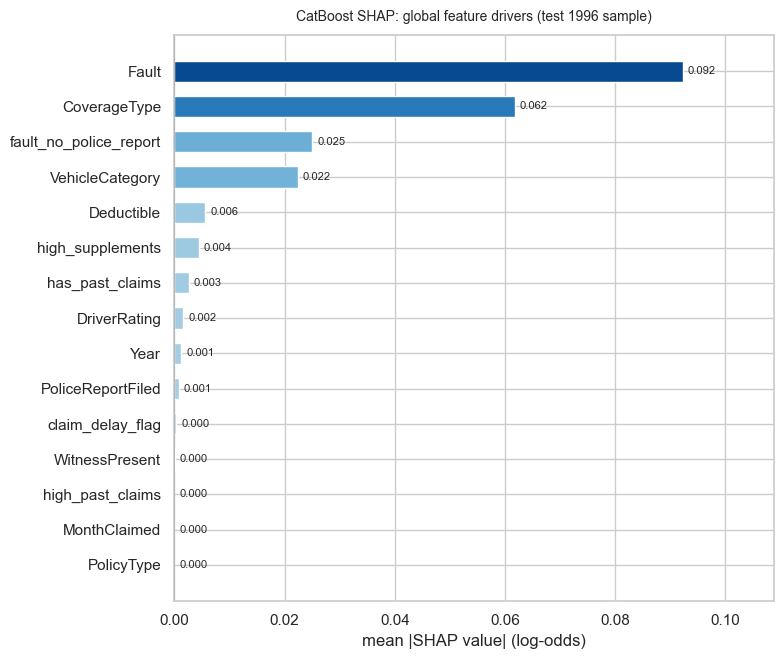


Selected indices:
  Top-1% (2 cases): [13242, 14104]
  FN outside Top-20% (2 cases): [15411, 13086]


In [97]:
# Global SHAP on sample

X_sample = X_96.sample(n=min(1000, len(X_96)), random_state=42)
base_val, contrib_sample = catboost_shap_values(final_model, X_sample, cat_idx)

plot_global_shap_bar(
    contrib_sample,
    top_n=15,
    title="CatBoost SHAP: global feature drivers (test 1996 sample)"
)


# Helper: pick cases for local SHAP

def topk_mask(scores: pd.Series, k: float) -> pd.Series:
    n = len(scores)
    m = max(1, int(np.ceil(k * n)))
    order = scores.rank(method="first", ascending=False)
    return order <= m

# Top-1% cases - highest risk
top1_mask = topk_mask(df_96["_score"], 0.01)
top1_idx = df_96[top1_mask].sort_values("_score", ascending=False).head(2).index.tolist()

# FN under Top-20% policy: fraud outside top-20%
top20_mask = topk_mask(df_96["_score"], 0.20)
fn_idx = df_96[(df_96["_y"] == 1) & (~top20_mask)].sort_values("_score", ascending=True).head(2).index.tolist()

print("\nSelected indices:")
print("  Top-1% (2 cases):", top1_idx)
print("  FN outside Top-20% (2 cases):", fn_idx)  

Global SHAP bar chart shows the average absolute SHAP value across all cases—that is, which features, on average, contribute most to the prediction. The longer the bar, the more important the feature is for the model as a whole.

This answers the question: "What does the model look at?"

Top-1% high-risk case #1 | y=0 | score=0.5313 | idx=13242
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = 0.1254      →  pred prob ≈ 0.5313



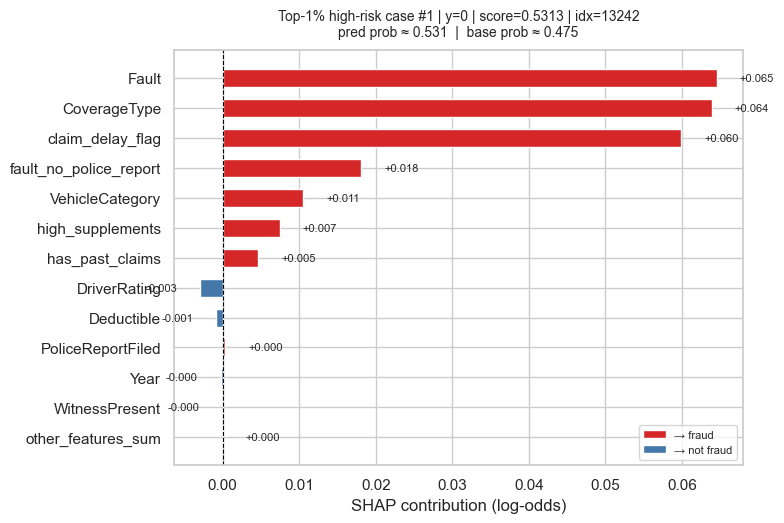

Top-1% high-risk case #2 | y=0 | score=0.5267 | idx=14104
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = 0.1068      →  pred prob ≈ 0.5267



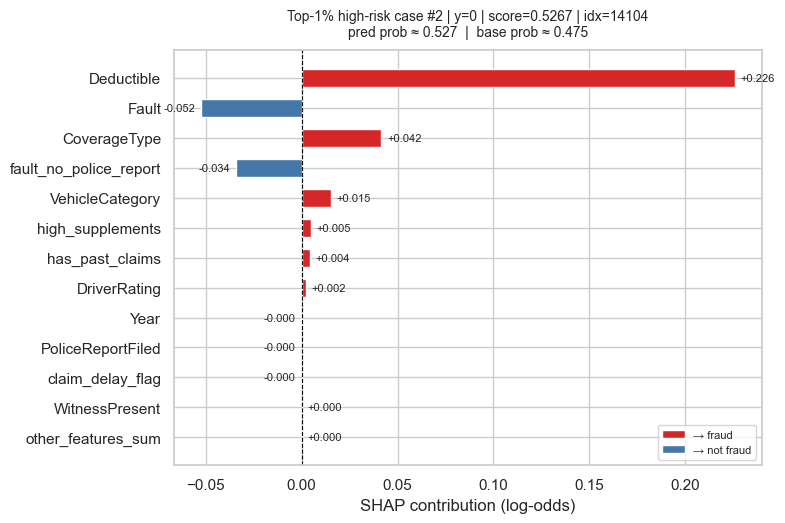

FN (missed fraud) case #1 | y=1 | score=0.4534 | idx=15411
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = -0.1868      →  pred prob ≈ 0.4534



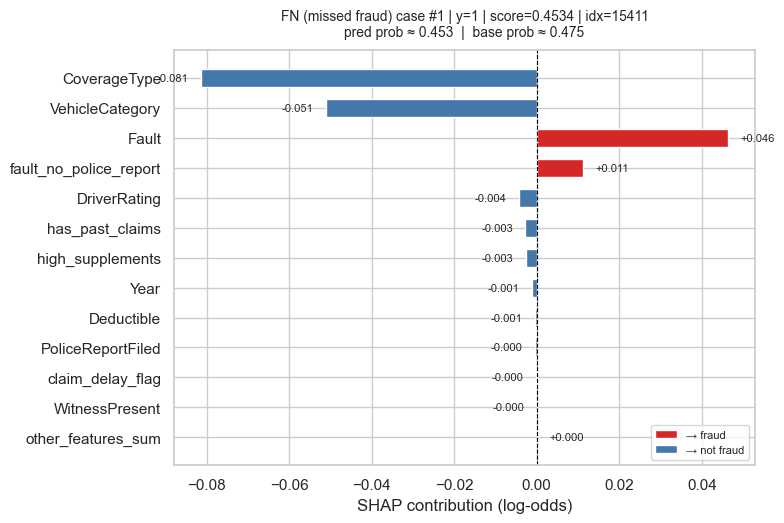

FN (missed fraud) case #2 | y=1 | score=0.4534 | idx=13086
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = -0.1868      →  pred prob ≈ 0.4534



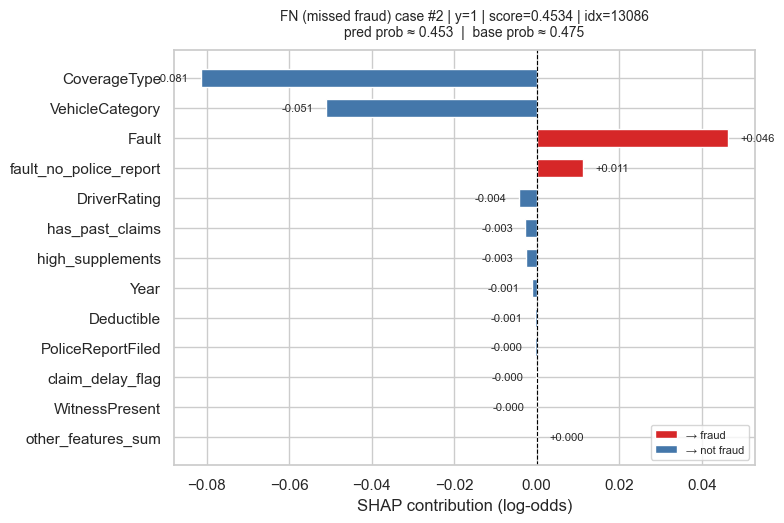

In [98]:
#  Local SHAP for selected cases

def explain_cases(case_indices, label: str):
    for i, idx in enumerate(case_indices, start=1):
        X_row = X_96.loc[[idx]]
        y_row = int(df_96.loc[idx, "_y"])
        s_row = float(df_96.loc[idx, "_score"])

        base_one, contrib_one = catboost_shap_values(final_model, X_row, cat_idx)
        contrib_row = contrib_one.iloc[0]

        title = f"{label} #{i} | y={y_row} | score={s_row:.4f} | idx={idx}"
        plot_local_shap(contrib_row, base_one, title=title, top_n=12)

explain_cases(top1_idx, "Top-1% high-risk case")
explain_cases(fn_idx, "FN (missed fraud) case")

Top-1% case #1
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = 0.1254      →  pred prob ≈ 0.5313



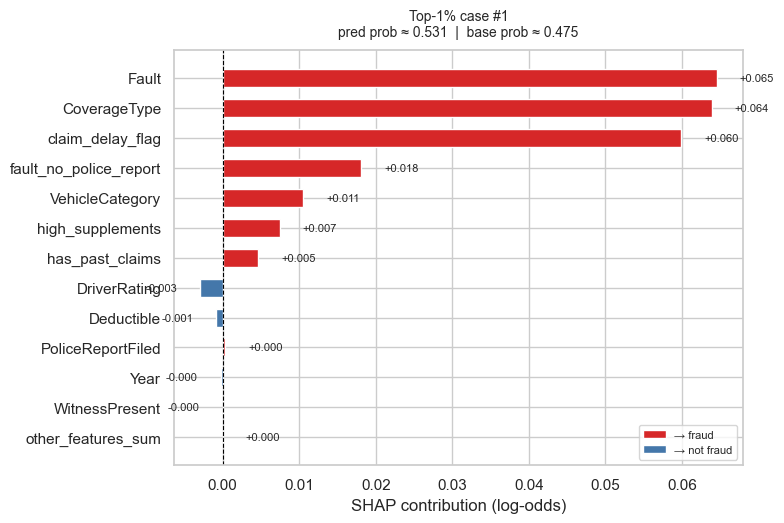

Top-1% case #2
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = 0.1068      →  pred prob ≈ 0.5267



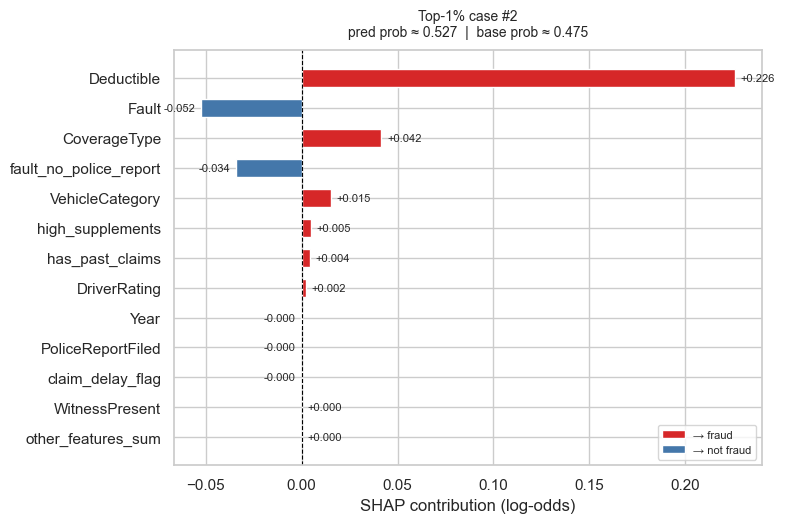

FN case #1 (missed fraud)
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = -0.1868      →  pred prob ≈ 0.4534



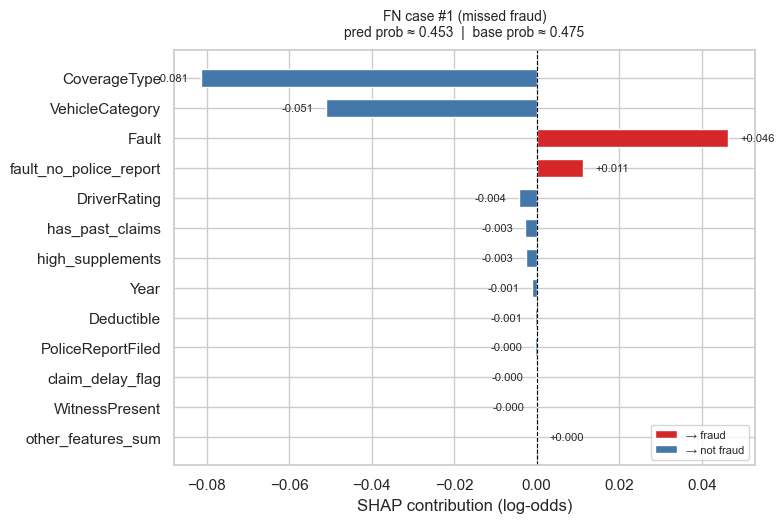

FN case #2 (missed fraud)
  base logit = -0.1000  →  base prob ≈ 0.4750
  pred logit = -0.1868      →  pred prob ≈ 0.4534



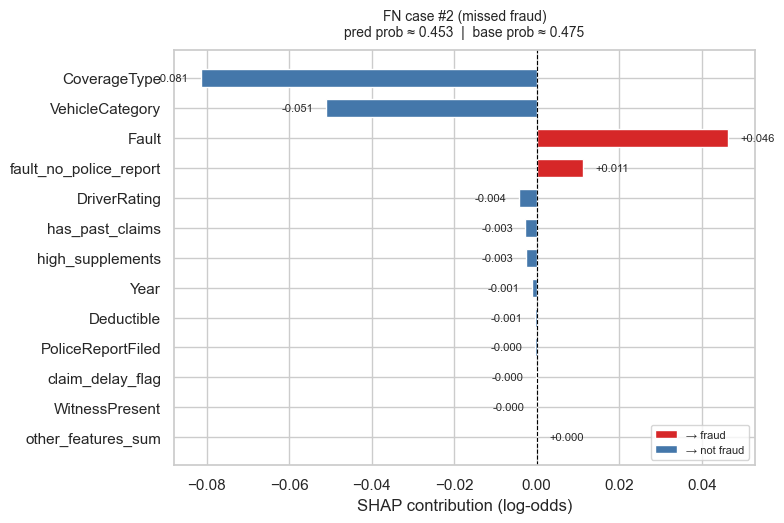

In [100]:
# Local SHAP Top-1% FN

for idx, label in zip(top1_idx, ["Top-1% case #1", "Top-1% case #2"]):
    _, contrib_all = catboost_shap_values(final_model, X_96, cat_idx)
    plot_local_shap(contrib_all.loc[idx], base_val, title=label)

for idx, label in zip(fn_idx, ["FN case #1 (missed fraud)", "FN case #2 (missed fraud)"]):
    _, contrib_all = catboost_shap_values(final_model, X_96, cat_idx)
    plot_local_shap(contrib_all.loc[idx], base_val, title=label)


### SHAP takeaways (CatBoost, Test 1996)

**Global drivers** 

SHAP shows that the CatBoost model relies primarily on **product/process signals**:
- strongest global drivers include **Fault**, **CoverageType**, and **VehicleCategory**, followed by process/behavior flags (e.g., `fault_no_police_report`, claim history proxies).

**Local explanations**
- Missed-fraud examples (FN) are often pushed **down** by strong negative contributions from product structure (notably **CoverageType**), which can override smaller red-flag signals.
- High-risk cases (Top-1%) are driven by a combination of product structure + fault/process indicators, consistent with the model acting as a prioritization tool.

**Consistency with Error Analysis**  
The dominance of CoverageType as a negative contributor in FN cases 
is consistent with the Error Analysis finding: the Sedan–Collision 
segment is systematically underscored, suggesting a structural blind 
spot rather than random error.

**Fairness / sensitivity note**
Demographic features (e.g., sex/age) do not appear among the top global drivers in this model, suggesting they are not primary decision factors (this is not a causal statement, but an importance signal).

## <a id="final-summary-ethical-reflection"></a>Final Summary & Ethical Reflection

### Final model:
We selected **CatBoost** as the final model because it achieved the strongest and most consistent **out-of-time** performance compared to linear baselines, indicating that fraud signal is driven by **non-linear interactions** between product and process features.

**Evaluation protocol:**
- Selection: train **1994** -> validate **1995**
- Final test: train **1994–1995** -> test **1996**
- Primary metrics: **PR-AUC (Average Precision)** and **Top-K prioritization metrics** (capacity-driven evaluation)

Best hyperparameters: depth=8, lr=0.03, l2_leaf_reg=10.0, 
selected via grid search optimized on ROC-AUC early stopping 
with PR-AUC as final selection criterion.


**Final test performance:**
- ROC-AUC: **0.780**
- PR-AUC (AP): **0.130**
- baseline prevalence: **0.052**

### Operational evaluation - Top-K prioritization:
We evaluate the model as a **risk-ranking tool**: claims are sorted by predicted fraud risk, and only the **top K%** are investigated.

**Test 1996:**
- **K = 1% (41 investigations):** TP=13, Precision≈31.7%, Recall≈6.1%, Lift≈6.08×
- **K = 10% (409 investigations):** TP=44, Precision≈10.8%, Recall≈20.7%, Lift≈2.06×
- **K = 20% (817 investigations):** TP=94, Precision≈11.5%, Recall≈44.1%, Lift≈2.21×

These results show that the model meaningfully **enriches fraud concentration** in the investigation queue (Lift@K > 1), allowing the business to choose K based on available investigation capacity and acceptable missed-fraud level.

### Error analysis - missed fraud under Top-20%:
Under a Top-20% policy, we compared fraud cases that were **caught** (TP) vs **missed** (FN).  
A major finding was a **coverage blind spot**:

- The segment **`Sedan - Liability__Liability`** had **1318** claims in 1996 with **10** fraud cases (≈0.76% fraud rate),
- yet **0%** of this segment entered the Top-20% queue because all scores were below the Top-20% cutoff.

**Interpretation:** the model learns this segment is generally low-risk and deprioritizes it entirely, which improves average queue efficiency but creates a systematic blind spot for rare fraud in this segment.

**Recommended policy-level mitigation:**
- Use a **stratified investigation policy** (reserve a small share of investigations to cover large low-risk segments), or
- enforce **minimum coverage rules** for monitoring and drift detection.

### Explainability (SHAP):
We used SHAP to validate which signals drive the CatBoost ranking:
- **Global drivers** were primarily **product/process features** (e.g., Fault, CoverageType, VehicleCategory, and process flags),
- Local explanations of missed-fraud cases showed that some product/coverage patterns can strongly pull risk **down**, consistent with the blind-spot findings.

Notably, demographic features (e.g., sex/age) did not appear among the top global drivers, suggesting they are not primary factors in the model’s prioritization (SHAP indicates associations, not causality).


## Dataset limitations and potential biases:
- **Label uncertainty:** `FraudFound_P` is insurer-provided; without documentation it may reflect confirmed fraud, suspected fraud, or process-driven labeling.
- **Temporal drift:** performance changes over time; 1996 appears to differ from earlier years (process/policy changes or fraud pattern drift).
- **Small time horizon:** only three years are available, limiting robust temporal cross-validation.
- **Class imbalance:** fraud is a minority class (~6%), making evaluation sensitive to the chosen operational policy.

## Risks of harm from misclassification:
- **False positives (FP):** unnecessary investigations, customer friction, potential unfair treatment if used improperly.
- **False negatives (FN):** missed fraud can lead to financial loss and may allow repeated fraud behavior.
- **Segment blind spots:** deprioritizing entire segments can cause systematic misses of rare fraud types.
- **Proxy discrimination:** even without explicit demographic features, product/geographic features may act as proxies for protected characteristics (e.g., AccidentArea as geographic proxy).

## Mitigation strategies:
- **Human-in-the-loop:** the model should prioritize investigation, not auto-deny claims.
- **Policy design:** choose K based on capacity; consider stratified sampling to avoid zero-coverage segments.
- **Transparency:** communicate that the model outputs a ranking score, not a definitive fraud verdict.
- **Monitoring & retraining:** track performance drift over time and retrain periodically.

## Data growth - more data could improve results:
Given the limited generalization across years and observed blind spots, improved performance would likely require:
- **More labeled samples**, especially for rare fraud pockets (e.g., low-risk segments with occasional fraud).
- **Better coverage of edge cases** and segment diversity (more examples per product/coverage combination).
- **Richer features** that reflect investigation-relevant signals available at claim time (e.g., additional process metadata).
- Potentially, **ongoing data collection** aligned to the operational policy (e.g., ensuring some investigation coverage in low-risk segments to obtain labels).